## Import Required Libraries
##### Train models
1. Keras

##### Visualization
1. Matplotlib
2. Seaborn
3. colorcet

##### Data manipulation
1. Numpy
2. Pandas

##### Metrics
1. Sklearn

##### Utils
1. os
2. shutil
3. datetime

In [1]:

import os
from os import listdir
import shutil
from os.path import join
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import colorcet as cc

import numpy as np
from pandas import DataFrame, concat

from tensorflow import keras
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge
from keras.applications import resnet, vgg16, vgg19, xception, inception_v3, inception_resnet_v2, mobilenet, densenet, nasnet
from keras.layers import Conv2D, Reshape, Embedding, Concatenate, Dense, LayerNormalization, BatchNormalization, Dropout, Input, Layer, Flatten
from keras import layers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import Accuracy, AUC, Recall, Precision, CategoricalAccuracy
from keras import optimizers

from sklearn.metrics import classification_report, confusion_matrix

### Downloading the Data

The datasets used in this notebook can be downloaded from Kaggle using the Kaggle API.
The following code is used to download and extract the datasets in the proper data folder.


In [16]:
!pip install kaggle --quiet
root_dir = "data"
drive.mount('/content/drive', force_remount=True)
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Colab Notebooks/"

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip -q brain-mri-images-for-brain-tumor-detection.zip -d data/brain_tumor

 99% 15.0M/15.1M [00:01<00:00, 22.2MB/s]
100% 15.1M/15.1M [00:01<00:00, 15.1MB/s]


In [17]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
!unzip -q augmented-alzheimer-mri-dataset.zip -d data/alzheimer

100% 379M/380M [00:19<00:00, 18.9MB/s]
100% 380M/380M [00:19<00:00, 20.2MB/s]


In [ ]:
!kaggle datasets download -d afridirahman/brain-stroke-ct-image-dataset
!unzip -q brain-stroke-ct-image-dataset.zip -d data/stroke

 81% 49.0M/60.4M [00:00<00:00, 83.3MB/s]
100% 60.4M/60.4M [00:00<00:00, 90.1MB/s]


In [21]:
drive.flush_and_unmount()

# Brain tumor

### Folder Structure
Sets up the folder structure required for storing brain tumor image data. It creates the necessary directories, including the root directory for the brain tumor data, the subdirectories for training and testing data, and the classes representing the presence and absence of brain tumors. The organized folder structure facilitates efficient data loading and management for further processing and analysis.

In [3]:
brain_tumor_dir = join(root_dir, 'brain_tumor')
brain_tumor_train_path = join(brain_tumor_dir, 'train')
brain_tumor_test_path = join(brain_tumor_dir, 'test')
brain_tumor_classes = ['yes', 'no']

def make_brain_tumor_folders():
  if not os.path.exists(brain_tumor_dir):
    if not os.path.exists(root_dir):
      os.makedirs(root_dir)
    os.makedirs(brain_tumor_dir)
    os.makedirs(brain_tumor_train_path)
    os.makedirs(brain_tumor_test_path)

make_brain_tumor_folders()

## Data Split: Train and Test

To ensure proper evaluation and validation of the model, the function `split_train_test_data` is employed to divide the brain tumor image data into training and test sets. This function creates directories for each class in the dataset, such as 'yes' and 'no', under the 'train' and 'test' folders respectively. The function then shuffles the images and splits them into training and test sets based on the specified `test_ratio`. The training and test sets are copied to their respective directories to facilitate further data processing and analysis for model training and evaluation.


In [4]:
def split_train_test_data(images_dir: str, classes, test_ratio: float=0.1):
  for i in classes:
      train_dir = join(images_dir, 'train', i)
      test_dir = join(images_dir, 'test', i)
      if not os.path.exists(train_dir):
          os.makedirs(train_dir)
      if not os.path.exists(test_dir):
          os.makedirs(test_dir)
      source = join(images_dir, i)

      allFileNames = os.listdir(source)

      np.random.shuffle(allFileNames)

      test_ratio = test_ratio

      train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])

      train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
      test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

      for name in train_FileNames:
          shutil.copy(name, train_dir)

      for name in test_FileNames:
          shutil.copy(name, test_dir)

In [6]:
split_train_test_data(images_dir=brain_tumor_dir, classes=brain_tumor_classes)

## Analyzing the dataset

We analyze the dataset to understand its distribution and balance and see example of pictures for each class. This helps us choose a machine learning algorithm and set hyperparameters.

* Analyze the distribution and balance of the dataset.
* Create bar plots and a grid of images to visualize the data.
* Use this analysis to choose a machine learning algorithm and set hyperparameters.


In [15]:
PALETTE = sns.color_palette("Dark2")

def plot_dataset_balance(train_path: str, test_path:str, classes: list[str]):
  train_samples = {}
  test_samples = {}

  for class_name in classes:
    train_samples[class_name] = len(os.listdir(os.path.join(train_path, class_name)))
    test_samples[class_name] = len(os.listdir(os.path.join(test_path, class_name)))


  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  sns.barplot(x=list(train_samples.keys()), y=list(train_samples.values()), palette=PALETTE, ax=ax[0])
  ax[0].set_title('Training Samples')
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

  sns.barplot(x=list(test_samples.keys()), y=list(test_samples.values()), palette=PALETTE, ax=ax[1])
  ax[1].set_title('Test Samples')
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
  plt.show()

def show_example_grid(train_path: str, classes):
  num_classes = len(classes)
  num_examples = 5
  fig, ax = plt.subplots(num_classes, num_examples, figsize=(15,11))
  fig.suptitle('Image examples', fontsize=30)
  samples = []
  paths = []
  for class_name in classes:
    samples.append(os.listdir(join(train_path, class_name))[:num_examples])
    paths.append(join(train_path, class_name))

  for i in range(num_classes):
      for j in range(num_examples):
          image_path = join(paths[i], samples[i][j])
          image = img.imread(image_path)
          ax[i, j].imshow(image)
          ax[i, j].set_title(classes[i], fontsize=20, color=PALETTE[i])
          ax[i, j].axis('off')
          ax[i, j].tick_params(axis='both', which='both', length=0)
  plt.tight_layout()

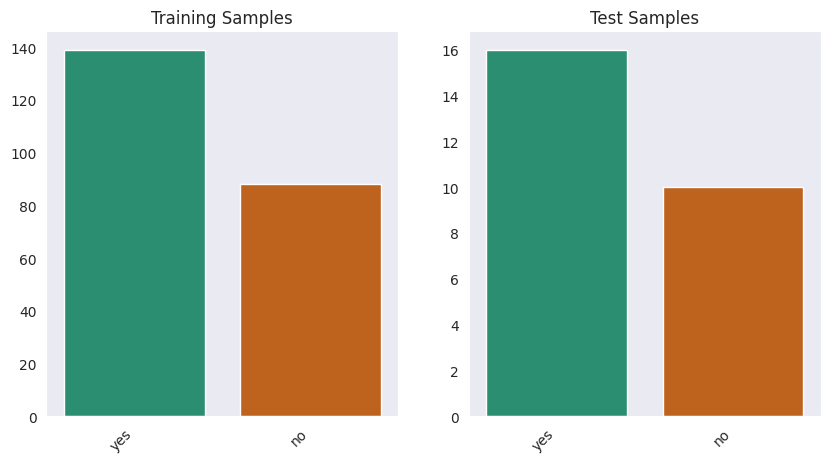

In [ ]:
plot_dataset_balance(brain_tumor_train_path, brain_tumor_test_path, brain_tumor_classes)

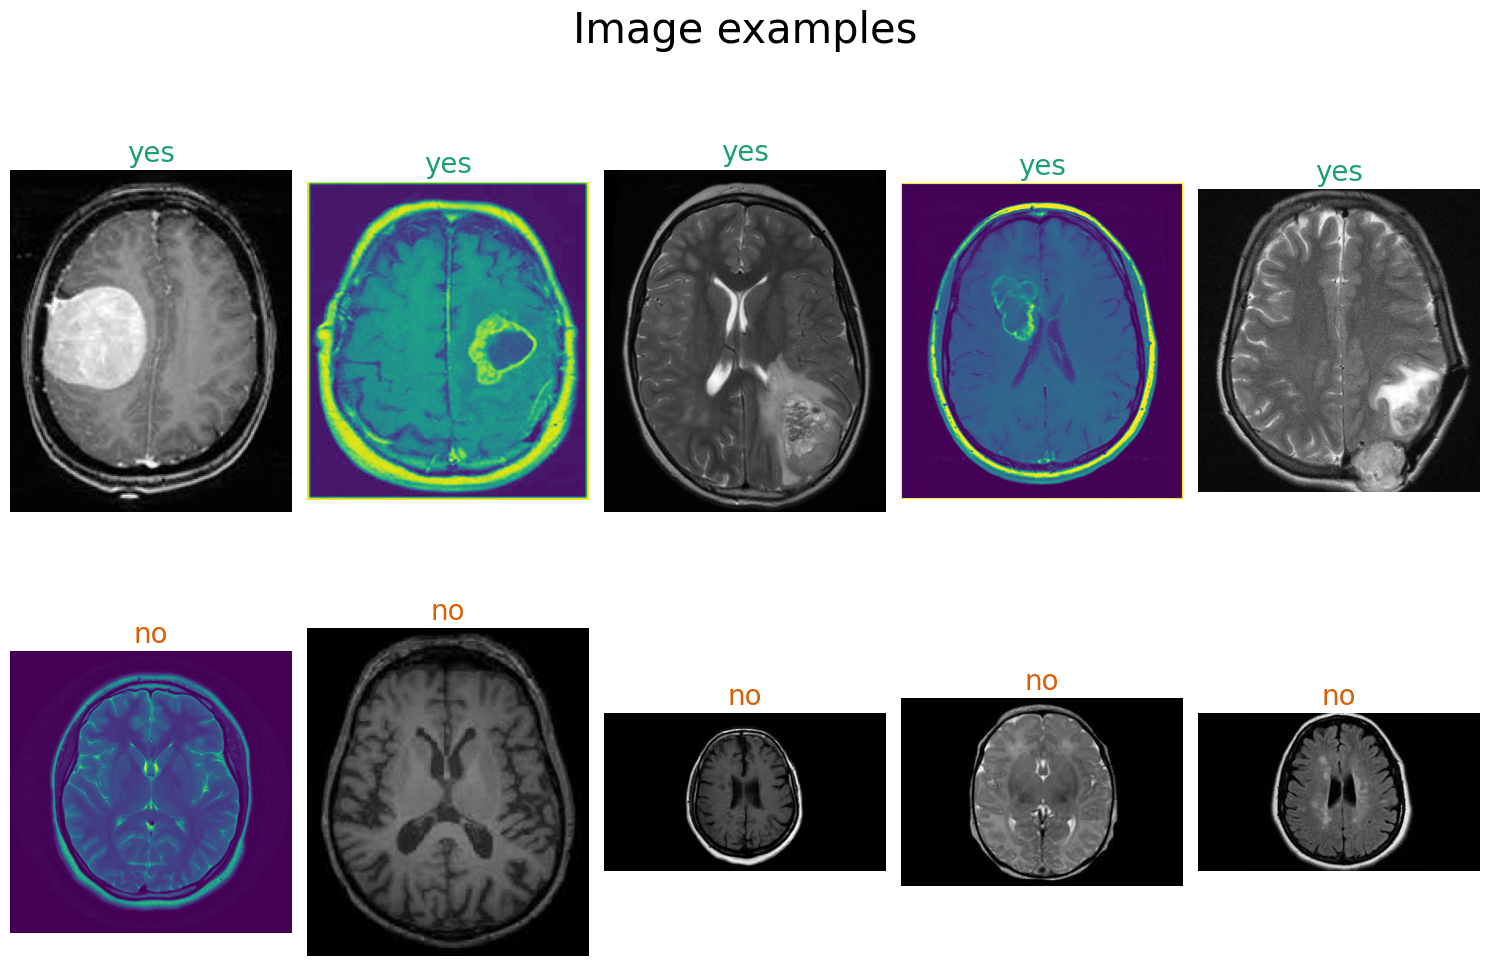

In [16]:
show_example_grid(brain_tumor_train_path, brain_tumor_classes)

## Creating the data generators

We will create the data generators for the training, validation, and test data. The data generators will load images from a directory, resize the images, and apply random transformations to the images. This helps to prevent overfitting and to improve the performance of the model.

The data generators will be used to train, validate, and test our model.


### Training, validation, and testing sets

The training set is used to train the model, the validation set is used to evaluate the performance of the model, and the testing set is used to evaluate the performance of the model on unseen data.

It is important to use different sets to prevent overfitting. Overfitting occurs when the model learns the training data too well and is not able to generalize to new data.


In [17]:
# Define the image size
IMAGE_SIZE = 224

# Define the batch size
BATCH_SIZE = 32

INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

def get_generators(train_path: str, test_path: str, preprocessing_function, batch_size: int=BATCH_SIZE, image_shape=(IMAGE_SIZE, IMAGE_SIZE), class_mode: str='binary', validation_split: float=0.1, augment_training_data: bool=False):

  if augment_training_data:
    # Define the data generator for training data
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rotation_range=90, # randomly rotate images by 20 degrees
        width_shift_range=0.2, # randomly shift images horizontally by 20%
        height_shift_range=0.2, # randomly shift images vertically by 20%
        shear_range=0.2, # randomly apply shearing transformations
        zoom_range=0.2, # randomly zoom in on images
        horizontal_flip=True, # randomly flip images horizontally
        vertical_flip=True, # randomly flip images vertically
        fill_mode='nearest', # fill any empty pixels with the nearest pixel value
        validation_split=validation_split
    )
  else:
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function, validation_split=validation_split)


  # Define the data generator for validation data
  test_datagen = keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=preprocessing_function
  )

  # Define the training data generator
  train_generator = train_datagen.flow_from_directory(
      train_path, # path to the training data directory
      target_size=image_shape, # resize images to (IMG_SIZE, IMG_SIZE)
      batch_size=batch_size, # set the batch size
      class_mode=class_mode, # set the class mode to binary classification
      shuffle=True,
      subset='training'
  )

  # Define the validation data generator
  val_generator = train_datagen.flow_from_directory(
      train_path, # path to the validation data directory
      target_size=image_shape, # resize images to (IMG_SIZE, IMG_SIZE)
      batch_size=batch_size, # set the batch size
      class_mode=class_mode, # set the class mode to binary classification
      shuffle=True,
      subset='validation'
  )

  test_generator = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=image_shape,
                                             batch_size=batch_size,
                                             class_mode=class_mode)

  return train_generator, val_generator, test_generator

In [18]:
brain_tumor_train_data, brain_tumor_val_data, brain_tumor_test_data = get_generators(brain_tumor_train_path, brain_tumor_test_path, vgg16.preprocess_input, validation_split=0.25, augment_training_data=True)

Found 171 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


## Defining the CNN model

We will start with a custom CNN to test performance on this problem. The model will be compiled with binary cross-entropy loss and the Adam optimizer.


In [19]:
def get_custom_CNN():
  # Define the CNN model
  model = keras.Sequential([
      # First convolutional layer
      keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      # Second convolutional layer
      keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      # Third convolutional layer
      keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      # Flatten the output from the convolutional layers
      keras.layers.Flatten(),
      # Add a fully connected layer with 512 hidden units and ReLU activation
      keras.layers.Dense(512, activation='relu'),
      # Add a dropout layer to prevent overfitting
      keras.layers.Dropout(0.5),
      # Add the output layer with sigmoid activation for binary classification
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model with binary cross-entropy loss and Adam optimizer
  return model

In [20]:
model = get_custom_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

### Metrics and loss

We will use the following metrics to evaluate the performance of the model:

* **Accuracy:** This metric measures the percentage of images that were correctly classified.
* **AUC:** This metric measures the area under the receiver operating characteristic curve. It is a good measure of the model's ability to distinguish between positive and negative classes.
* **Precision:** This metric measures the fraction of positive predictions that were actually positive.
* **Recall:** This metric measures the fraction of positive samples that were correctly identified as positive.

We chose binary cross-entropy loss because it is a commonly used loss function for binary classification problems. It measures the distance between the predicted probabilities and the ground truth labels. We also chose the Adam optimizer because it is a popular choice for training deep learning models. It is a stochastic gradient descent optimizer that is known for its fast convergence and good performance.

These metrics are all important for evaluating the performance of a binary classification model. Accuracy is a good overall measure of performance, but it can be misleading if the classes are imbalanced. AUC is a more robust measure of performance that is not affected by class imbalance. Precision and recall measure different aspects of the model's performance, and they can be used together to get a more complete picture of the model's performance.


In [21]:
metrics = {'accuracy': 'accuracy',
           'auc': AUC(name='auc'),
           'precision': Precision(name='precision'),
           'recall': Recall(name='recall')}

# Compile the CNN model with an appropriate loss function, optimizer, and metrics
def compile_model(model, loss='binary_crossentropy', optimizer='adam', num_classes: int=2):
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=list(metrics.values()))
    return model

## Training the model

We will train the CNN model on the training data and validate it on the testing data. The model will be trained for 10 epochs, which is not enough to reach good validation accuracy. However, it will give us a good indication if this model could perform well after a longer training.

In [22]:
# Train the CNN model on the training data and validate it on the testing data
model = compile_model(model)

def fit_model(model, train_data, val_data, epochs: int=10):
  history = model.fit(
      train_data, # training data generator
      epochs=epochs, # number of epochs to train for
      validation_data=val_data # testing data generator
  )
  return history

The CNN model was trained for 10 epochs. The training loss decreased over time, but the validation loss remained relatively high. This suggests that the model is overfitting to the training data.

The validation accuracy and AUC also remained relatively low, which indicates that the model is not very good at distinguishing between positive and negative classes.

The best validation accuracy and AUC were achieved at epoch 6, with a value of 0.7273 and 0.7734, respectively. However, these values are still relatively low, suggesting that the model could be improved.

In [23]:
fit_model(model, brain_tumor_train_data, brain_tumor_val_data)

Epoch 1/10
6/6 [==============================] - 17s 2s/step - loss: 392.0401 - accuracy: 0.4737 - auc: 0.4405 - precision: 0.5743 - recall: 0.5524 - val_loss: 9.2941 - val_accuracy: 0.3929 - val_auc: 0.4225 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 13s 2s/step - loss: 5.2742 - accuracy: 0.5088 - auc: 0.4853 - precision: 0.6082 - recall: 0.5619 - val_loss: 0.9388 - val_accuracy: 0.4107 - val_auc: 0.7333 - val_precision: 1.0000 - val_recall: 0.0294
Epoch 3/10
6/6 [==============================] - 13s 2s/step - loss: 1.3784 - accuracy: 0.5146 - auc: 0.4969 - precision: 0.6058 - recall: 0.6000 - val_loss: 0.7027 - val_accuracy: 0.5000 - val_auc: 0.6939 - val_precision: 0.8000 - val_recall: 0.2353
Epoch 4/10
6/6 [==============================] - 13s 2s/step - loss: 0.7278 - accuracy: 0.6608 - auc: 0.6896 - precision: 0.7196 - recall: 0.7333 - val_loss: 0.6175 - val_accuracy: 0.6429 - val_auc: 0.7948 - val_precision: 0.6296 - v

## Evaluating the model

We will evaluate the performance of the trained CNN model on the unseen testing data.

The results are not promising, with a low test loss and accuracy of only 0.3846. The AUC is also low, at 0.5, which suggests that the model is not very good at distinguishing between positive and negative classes.

These results suggest that the model needs a different architecture. For example, the model could be made deeper or with different hyper-parameters.

In [24]:
def evaluate_model(model, test_data):
  # Evaluate the performance of the trained CNN model on the testing data
  metrics_results = {}
  results = model.evaluate(test_data, batch_size=32)
  metrics_results['loss'] = results.pop(0)
  metrics_results.update({metric: result for metric, result in zip(metrics.keys(), results)})

  # Print the test loss and accuracy
  print('Test loss:', metrics_results['loss'])
  print('Test accuracy:', metrics_results['accuracy'])
  print('Test AUC:', metrics_results['auc'])

In [ ]:
evaluate_model(model, brain_tumor_test_data)

1/1 [==============================] - 0s 394ms/step - loss: 12.6744 - accuracy: 0.3846 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00
[0.38461539149284363, 0.5, 0.0, 0.0]
Test loss: 12.674432754516602
Test accuracy: 0.38461539149284363
Test AUC: 0.5


## Transfer Learning

Instead of creating model architecture and learning from scratch, we are going to use models that have shown their potential in medical imaging computer vision problems. We will do what we refer to as **transfer learning**. This involves taking a pre-trained model, such as ResNet50 or VGG16, and fine-tuning it for our specific task.

We will test some of these models in our datasets to see how well they perform. We will allow for **binary classification** as well as **multi-class classification**.

In binary classification, we will use the model to predict whether an image contains a specific abnormality or not. For example, we could use a binary classifier to predict whether an image contains a tumor or not.

In multi-class classification, we will use the model to predict the class of an image. For example, we could use a multi-class classifier to predict the type of alzheimer stage that is present in an image.

We will evaluate the performance of the transfer learning models using accuracy, precision, recall, and F1 score. We will also visualize the model predictions to get a better understanding of how the models are working.

Here are some of the pre-trained models that we will test:

* ResNet50
* VGG16
* VGG19
* InceptionV3
* Xception
* MobileNet
* DenseNet

To perform transfer learning using pretrained CNN models, we simply need to construct a classifier on top of the existing pretrained model. Initially, we can train the classifier while keeping the pretrained model frozen. However, for improved performance, it is advisable to unfreeze the pretrained model and fine-tune it for our specific task at some stage.


In [9]:
model_dict = {
    ResNet50: resnet.preprocess_input,
    VGG16: vgg16.preprocess_input,
    VGG19: vgg19.preprocess_input,
    Xception: xception.preprocess_input,
    InceptionV3: inception_v3.preprocess_input,
    InceptionResNetV2: inception_resnet_v2.preprocess_input,
    MobileNet: mobilenet.preprocess_input,
    DenseNet121: densenet.preprocess_input,
    DenseNet169: densenet.preprocess_input,
    DenseNet201: densenet.preprocess_input,
    NASNetMobile: nasnet.preprocess_input,
    NASNetLarge: nasnet.preprocess_input
}

def get_binary_transfer_model(transfer_model, dropout_rate=0.5, loss='binary_crossentropy', optimizer='adam', image_shape=(IMAGE_SIZE, IMAGE_SIZE)):
  input_shape = (image_shape[0], image_shape[1], 3)
  base_model = transfer_model(input_shape=input_shape, weights='imagenet', include_top=False)
  base_model.trainable = False
  inputs = keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = Dropout(dropout_rate)(x)
  outputs = Dense(1, activation = 'sigmoid')(x)
  model = Model(inputs, outputs)
  model.summary()
  model = compile_model(model, loss=loss, optimizer=optimizer)
  return model

def get_multiclass_transfer_model(transfer_model, num_classes: int, dropout_rate=0.5, loss='categorical_crossentropy', optimizer='adam', image_shape=(IMAGE_SIZE, IMAGE_SIZE)):
  input_shape = (image_shape[0], image_shape[1], 3)
  base_model = transfer_model(input_shape=input_shape, weights='imagenet', include_top=False)
  base_model.trainable = False
  inputs = keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = Dropout(dropout_rate)(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.summary()
  model = compile_model(model, loss=loss, optimizer=optimizer, num_classes=num_classes)
  return model

In [ ]:
model = get_binary_transfer_model(VGG16)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_____________________________________________

## Training the model

For improved reusability we create a convenient training method that trains the model on the training data and evaluates the model on the validation data. It can also saves the model to a file if a filepath is specified.

In [10]:
def train_model(model, train_data, val_data, epochs: int=10, filepath: str='', patience: int=10):
  if filepath:
    checkpoint = ModelCheckpoint(filepath=filepath, verbose=2, save_best_only=True)
    earlystopping = EarlyStopping(
    monitor="val_loss",
    patience=patience,
    restore_best_weights=True,
    start_from_epoch=5,
)
    callbacks = [checkpoint, earlystopping]
  else:
    callbacks = []
  start = datetime.now()

  model_history=model.fit(
                        train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_steps=len(val_data),
                        callbacks=callbacks,
                        verbose=2)


  duration = datetime.now() - start
  print("Training completed in time: ", duration)
  return model_history

In [ ]:
model_history = train_model(model, brain_tumor_train_data, brain_tumor_val_data, filepath='brain_vgg16.h5', epochs=50)

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.11562, saving model to brain_vgg16.h5
6/6 - 31s - loss: 1.4818 - accuracy: 0.5673 - auc: 0.5365 - precision: 0.6084 - recall: 0.8286 - val_loss: 1.1156 - val_accuracy: 0.6071 - val_auc: 0.6049 - val_precision: 0.6875 - val_recall: 0.6471 - 31s/epoch - 5s/step
Epoch 2/50

Epoch 2: val_loss did not improve from 1.11562
6/6 - 9s - loss: 1.2897 - accuracy: 0.5146 - auc: 0.5168 - precision: 0.6122 - recall: 0.5714 - val_loss: 1.3620 - val_accuracy: 0.4107 - val_auc: 0.5167 - val_precision: 0.5217 - val_recall: 0.3529 - 9s/epoch - 2s/step
Epoch 3/50

Epoch 3: val_loss improved from 1.11562 to 0.98787, saving model to brain_vgg16.h5
6/6 - 4s - loss: 1.0611 - accuracy: 0.5439 - auc: 0.5541 - precision: 0.6364 - recall: 0.6000 - val_loss: 0.9879 - val_accuracy: 0.5357 - val_auc: 0.5729 - val_precision: 0.6053 - val_recall: 0.6765 - 4s/epoch - 720ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.98787 to 0.90913, saving model to brain_vgg1

## Evaluating the model

Once the model is trained, we can evaluate its performance on the test data. Therefore we create a series of utils functions to display and save the results.
We can plot the model's training and validation metrics to see how they change over time. This can help us to identify any problems with the model's training process.

Finally, we can create a confusion matrix to see how the model is classifying the test images. The confusion matrix shows the number of images that were correctly classified and the number of images that were misclassified. For more details we could take a look at the classification report as well.

In [38]:
def get_predictions(model, test_gen, binary: bool=False):
    if binary:
      y_pred = np.where(model.predict(test_gen) >= 0.5, 1, 0)
      y_true = test_gen.labels
      return y_pred, y_true

    data, y_true = test_gen.next()
    y_pred_ = model.predict(data)
    y_pred = []
    for i in range(y_pred_.shape[0]):
      y_pred.append(np.argmax(y_pred_[i]))

    y_true = np.argmax(y_true, axis=1)

    return y_true, y_pred

def save_model_history(model_history, filename: str):
  data = DataFrame(model_history.history)
  data.to_csv(filename)

def plot_confusion_matrix(y_true, y_pred, classes):
  cm = confusion_matrix(y_true, y_pred, labels=[i for i in range(len(classes))])
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

  # Set labels, title, and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes, rotation=30, ha='right')
  ax.yaxis.set_ticklabels(classes, rotation=0)
  plt.show()

def melt_metrics(data):
  data.index += 1
  data.reset_index(inplace=True)
  data.rename(columns={'index': 'epochs'}, inplace=True)

  melted = data.melt(id_vars='epochs', var_name='metric', value_name='value')
  dataset_mapping = {
      'accuracy': 'training',
      'auc': 'training',
      'loss': 'training',
      'precision': 'training',
      'recall': 'training',
      'categorical_accuracy': 'training',
      'val_accuracy': 'validation',
      'val_auc': 'validation',
      'val_loss': 'validation',
      'val_categorical_accuracy': 'validation',
      'val_precision': 'validation',
      'val_recall': 'validation',
  }

  category_mapping = {
      'accuracy': 'accuracy',
      'auc': 'auc',
      'loss': 'loss',
      'val_accuracy': 'accuracy',
      'val_auc': 'auc',
      'val_loss': 'loss',
      'precision': 'precision',
      'recall': 'recall',
      'categorical_accuracy': 'categorical_accuracy',
      'val_categorical_accuracy': 'categorical_accuracy',
      'val_precision': 'precision',
      'val_recall': 'recall',
      }

  melted['dataset'] = melted['metric'].map(dataset_mapping)
  melted['category'] = melted['metric'].map(category_mapping)
  return melted

def plot_metrics_lines(model_history):
  if isinstance(model_history, DataFrame):
    data = model_history
  else:
    data = DataFrame(model_history.history)

  sns.set_style("dark")
  accuracies_columns = ['accuracy', 'auc', 'val_accuracy', 'val_auc']
  losses_columns = ['loss', 'val_loss']
  metrics_columns = ['precision', 'recall', 'val_precision', 'val_recall']
  ordered_data = melt_metrics(data[accuracies_columns + metrics_columns + losses_columns].copy())
  g = sns.FacetGrid(ordered_data, col='category', hue='dataset', col_wrap=2, aspect=1.5, height=3, palette='mako_r', sharey=False)
  g.map(sns.lineplot, 'epochs', 'value')
  g.set_titles(col_template="{col_name}")

  pal = sns.color_palette("mako_r")
  color =  pal.as_hex()[-1]
  for i, ax in enumerate(g.axes.flat):
    if i < len(g.axes.flat) - 1:
      max_val = ax.lines[1].get_ydata().max()
      ax.axhline(max_val, ls='--', color=color, alpha=0.5)
      ax.text(1.0, max_val, f"{max_val:.2f}", ha='left', va='bottom', color=color)

    else:
        min_val = ax.lines[1].get_ydata().min()
        ax.axhline(min_val, ls='--', color=color)
        ax.text(0.95, min_val, f"{min_val:.2f}", ha='left', va='bottom', color=color)

  # Add legend
  g.add_legend()

  # Adjust the spacing between subplots
  plt.tight_layout()
  plt.suptitle('Model Training Metrics')
  plt.show()


def plot_experiment_info(model_history, y_true, y_pred, classes):
  plot_metrics_lines(model_history)
  plot_confusion_matrix(y_true, y_pred, classes)

## Running experiments

We define a series of pipeline that can be used to run the experiments. The code will train a model for each of the pre-trained models and then evaluate the model on the test data. The results of the experiments will be saved to a DataFrame.

This allows us to try many different variation easily to compare result and fine tune our models for each individual task.


In [12]:
def run_experiment_pipeline(transfer_model, train_path: str, test_path: str, model_name: str="", epochs: int=10, validation_split=0.25, augment_training_data=False, num_classes: int=2, optimizer='adam', image_shape=(IMAGE_SIZE, IMAGE_SIZE), plot_results: bool=True):
  train_data, val_data, test_data = get_generators(train_path, test_path, model_dict[transfer_model], validation_split=validation_split, augment_training_data=augment_training_data)
  if num_classes==2:
    model = get_binary_transfer_model(transfer_model, loss='binary_crossentropy', optimizer=optimizer, image_shape=image_shape)
  else:
    model = get_multiclass_transfer_model(transfer_model, num_classes, loss='categorical_crossentropy', optimizer=optimizer, image_shape=image_shape)

  print(transfer_model.__name__)
  model_name = f'{model_name}.h5' if model_name else ''
  model_history = train_model(model, train_data, val_data, filepath=model_name, epochs=epochs)

  if plot_results:
    plot_metrics_lines(model_history)

  return model, model_history

def run_training_pipeline(transfer_model, train_path: str, test_path: str, classes, model_name: str="", frozen_epochs: int=10, unfrozen_epochs: int=10, unfrozen_learning_rate: float=1e-5, validation_split=0.25, augment_training_data=False, optimizer='adam', image_shape=(IMAGE_SIZE, IMAGE_SIZE), plot_results: bool=True, patience: int=10):
  num_classes = len(classes)
  binary = num_classes == 2
  class_mode = 'binary' if binary else 'categorical'

  train_data, val_data, test_data = get_generators(train_path, test_path, model_dict[transfer_model], validation_split=validation_split, augment_training_data=augment_training_data, class_mode=class_mode)
  print(transfer_model.__name__)
  if num_classes==2:
    frozen_model = get_binary_transfer_model(transfer_model, loss='binary_crossentropy', optimizer=optimizer, image_shape=image_shape)
  else:
    frozen_model = get_multiclass_transfer_model(transfer_model, num_classes, loss='categorical_crossentropy', optimizer=optimizer, image_shape=image_shape)

  filepath = f'{model_name}.h5' if model_name else ''
  frozen_model_history = train_model(frozen_model, train_data, val_data, filepath=filepath, epochs=frozen_epochs, patience=patience)
  evaluate_model(frozen_model, test_data)

  if plot_results:
    y_true, y_pred = get_predictions(frozen_model, test_data, binary)
    plot_experiment_info(frozen_model_history, y_true, y_pred, classes)

  frozen_model.layers[1].trainable = True
  frozen_model.summary()
  adam = optimizers.Adam(unfrozen_learning_rate)
  unfrozen_model = compile_model(frozen_model, optimizer=adam)
  filepath = f'{model_name}_unfrozen.h5'
  unfrozen_model_history = train_model(unfrozen_model, train_data, val_data, filepath=filepath, epochs=unfrozen_epochs, patience=patience)
  evaluate_model(unfrozen_model, test_data)

  if plot_results:
    y_true, y_pred = get_predictions(unfrozen_model, test_data, binary)
    plot_experiment_info(unfrozen_model_history, y_true, y_pred, classes)

  return unfrozen_model, unfrozen_model_history

def compare_models(train_path: str, test_path: str, models: list[str] = list(model_dict.keys()), epochs: int=10):
  results = DataFrame()
  trained_models = {}
  for model in models:
    trained_model, model_history = run_experiment_pipeline(model, train_path, test_path, epochs=epochs)
    result = DataFrame(model_history.history)
    result['model'] = model.__name__
    results = concat([results, result])
    trained_models[model.__name__] = trained_model

  return trained_models, results

## Models Comparison

Once we have trained the models, we can compare their performance. We can do this by plotting the models' training and validation metrics over time. This will help us to identify which model is converging the fastest and which model is achieving the best performance.


In [13]:
def melt_models_comparison_results(results):
  columns_order = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'precision', 'val_precision', 'recall', 'val_recall', 'loss', 'val_loss', 'model']
  data = results[columns_order].copy()
  data = data.reset_index().rename(columns={'index': 'epochs'})
  melted = data.melt(id_vars=['epochs', 'model'], var_name='metric', value_name='value')
  return melted

def plot_models_comparison(results, classification_name: str):
  melted = melt_models_comparison_results(results)
  g = sns.FacetGrid(melted, col='metric', hue='model', col_wrap=2, aspect=1.5, height=3, palette=cc.glasbey, sharey=False)
  g.map(sns.lineplot, 'epochs', 'value', linewidth=2.5)
  g.set_titles(col_template="{col_name}")

   # Add legend
  g.add_legend(bbox_to_anchor=(1.02, 1), loc='upper left')

  color = 'b'
  for i, ax in enumerate(g.axes.flat):
    if i < len(g.axes.flat) - 2:
      max_val = max([y.get_ydata().max() for y in ax.lines])
      lines_with_max = [i for i, y in enumerate(ax.lines) if y.get_ydata().max() == max_val]
      legend_labels = [ax.get_legend_handles_labels()[1][i] for i in lines_with_max]
      best_model = legend_labels[0]
      ax.axhline(max_val, ls='--', color=color, alpha=0.5)
      ax.text(0.25, max_val, f"{best_model}: {max_val:.2f}", ha='left', va='bottom', color=color)

      for i, line in enumerate(ax.lines):
        if i in lines_with_max:
          line.set_linewidth(2.5)
        else:
          line.set_linewidth(1.0)
          line.set_alpha(0.60)

    else:
        min_val = min([y.get_ydata().min() for y in ax.lines])
        lines_with_min = [i for i, y in enumerate(ax.lines) if y.get_ydata().min() == min_val]
        legend_labels = [ax.get_legend_handles_labels()[1][i] for i in lines_with_min]
        best_model = legend_labels[0]
        ax.axhline(min_val, ls='--', color=color)
        ax.text(0.25, min_val, f"{best_model}: {min_val:.2f}", ha='left', va='top', color=color)

        for i, line in enumerate(ax.lines):
          if i in lines_with_min:
            line.set_linewidth(2.5)
            line.set_alpha(1.0)
          else:
            line.set_linewidth(1.0)
            line.set_alpha(0.60)

  # Adjust the spacing between subplots
  plt.suptitle(f'Model Comparison for {classification_name}')
  plt.tight_layout()
  plt.show()

## Training pipeline
Here we can see the result of making our model goes through the training pipeline. We reach an incredible score 0f 96% test accuracy and it took us only 3 minutes to train.

The training pipeline consists of the following steps:

1. Create the generators for the training, validation, and test datasets.
2. Create the model.
3. Freeze the base model
4. Train the model for a fixed number of epochs.
4. Evaluate the model on the test dataset.
5. Plot the training and validation curves.
6. Save the model's weights.
7. Unfreeze base model.
9. Start back from step 4 to 7

The pipeline can be run for a variety of pre-trained models and datasets. The following parameters can be customized:

* The number of frozen epochs.
* The number of unfrozen epochs.
* The learning rate for the unfrozen model.
* The validation split.
* Whether or not to augment the training data.
* The optimizer.
* The image shape.
* Whether or not to plot the results.

Found 206 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
VGG16
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                

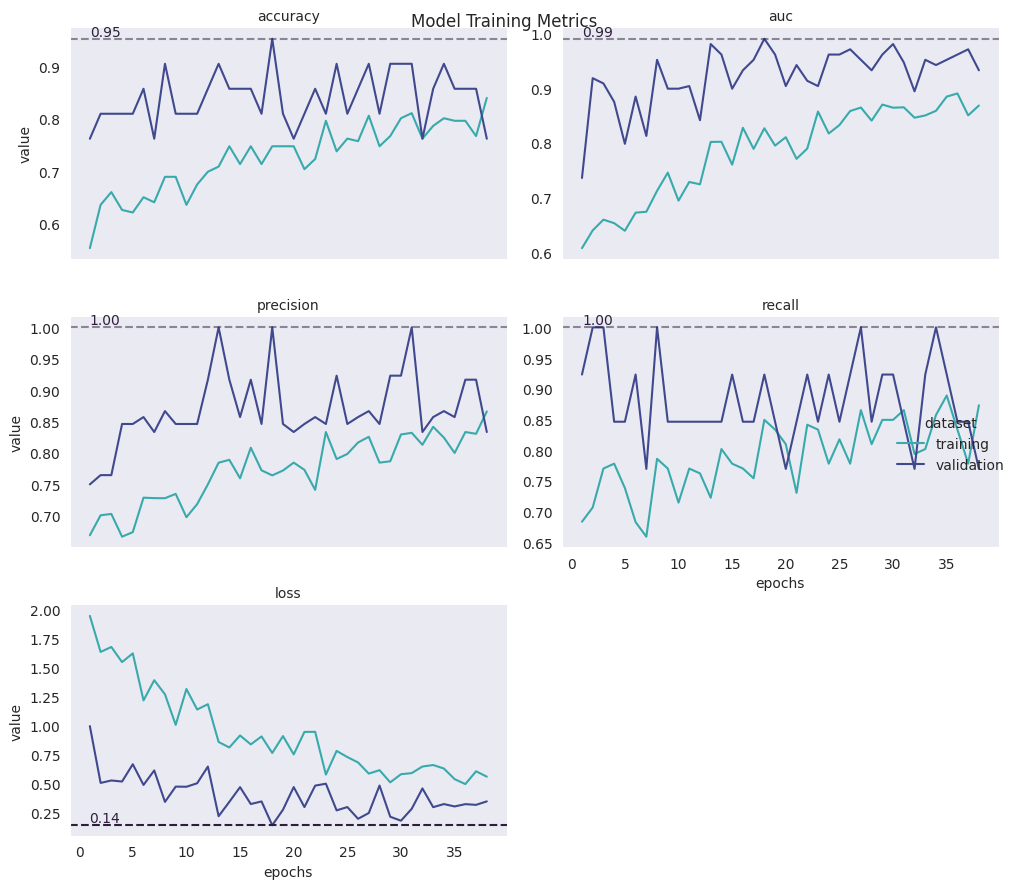

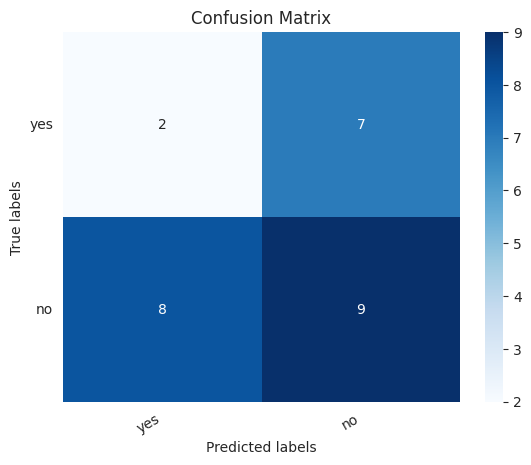

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_______________________________________________

1/1 [==============================] - 0s 265ms/step


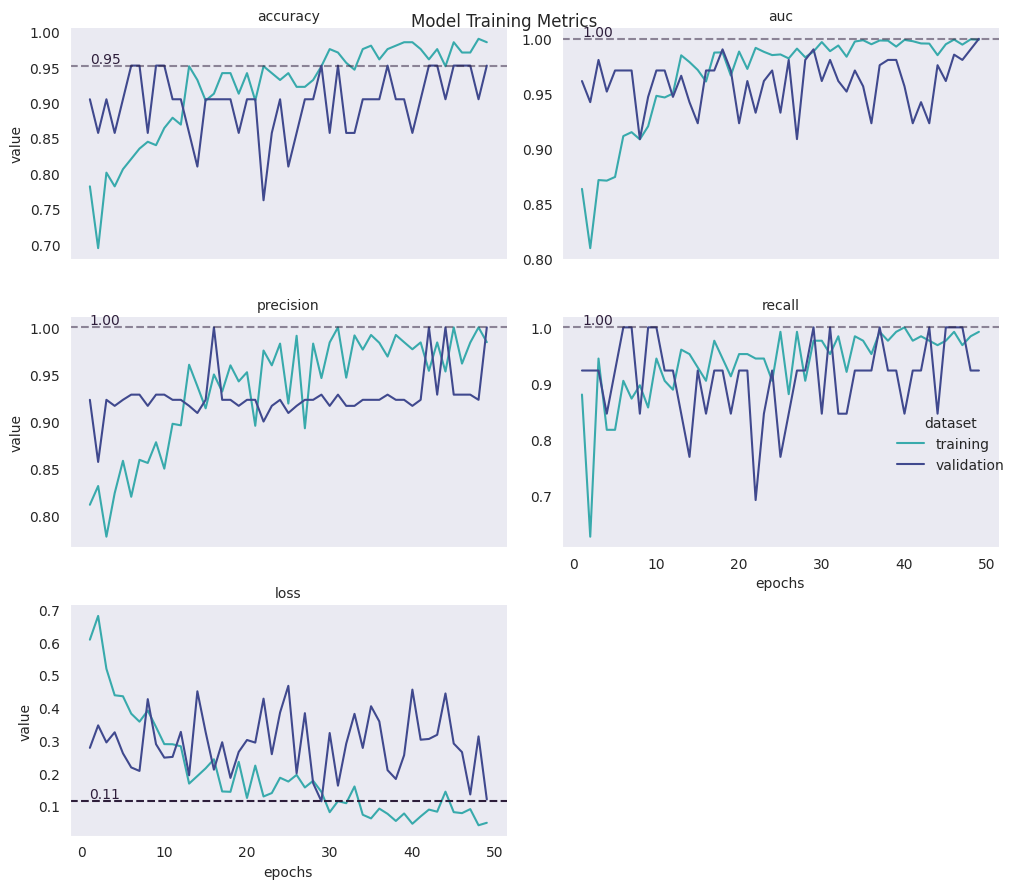

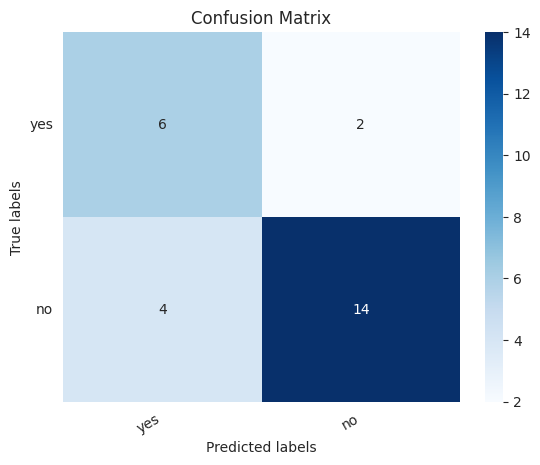

In [ ]:
trained_model, model_history = run_training_pipeline(VGG16, brain_tumor_train_path, brain_tumor_test_path, classes=brain_tumor_classes, model_name="brain_tumor_vgg16", frozen_epochs=150, unfrozen_epochs=50, validation_split=0.1, augment_training_data=True, plot_results=True)

# Alzheimer

## Alzheimer's dataset

We will now explore the Alzheimer's dataset. This dataset contains images of brain MRI scans from patients with different stages of Alzheimer's disease. The classes in the dataset are:

* NonDemented
* VeryMildDemented
* MildDemented
* ModerateDemented

In [26]:
alzheimer_dir = join(root_dir, "alzheimer")
alzheimer_train_path = join(alzheimer_dir, 'AugmentedAlzheimerDataset')
alzheimer_test_path = join(alzheimer_dir, 'OriginalDataset')
alzheimer_classes = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

We will first plot the distribution of the classes in the training and test datasets. This will help us to assess how balanced the dataset is.

The plot shows that the training dataset is relatively balanced, while the test dataset is slightly imbalanced. This is because the original dataset was not balanced, and we only augmented the training dataset.

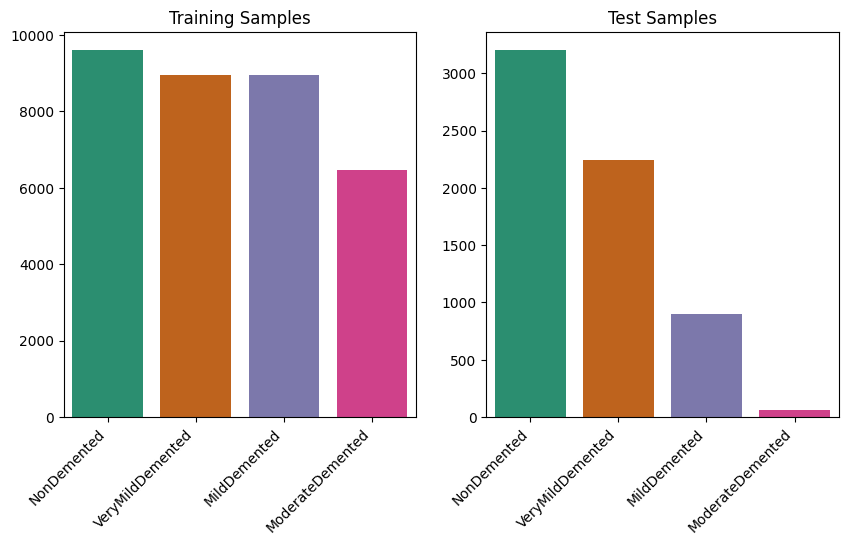

In [28]:
plot_dataset_balance(alzheimer_train_path, alzheimer_test_path, alzheimer_classes)

We can also visualize some of the images in the dataset. This will help us to get a better understanding of the data.

The grid shows some examples of images from each of the classes in the dataset. The images are labeled with the class name and the patient's age.

This is a small sample of the data, but it gives us a good overview of the dataset. The images are of varying quality, but they are all clear enough to be classified.

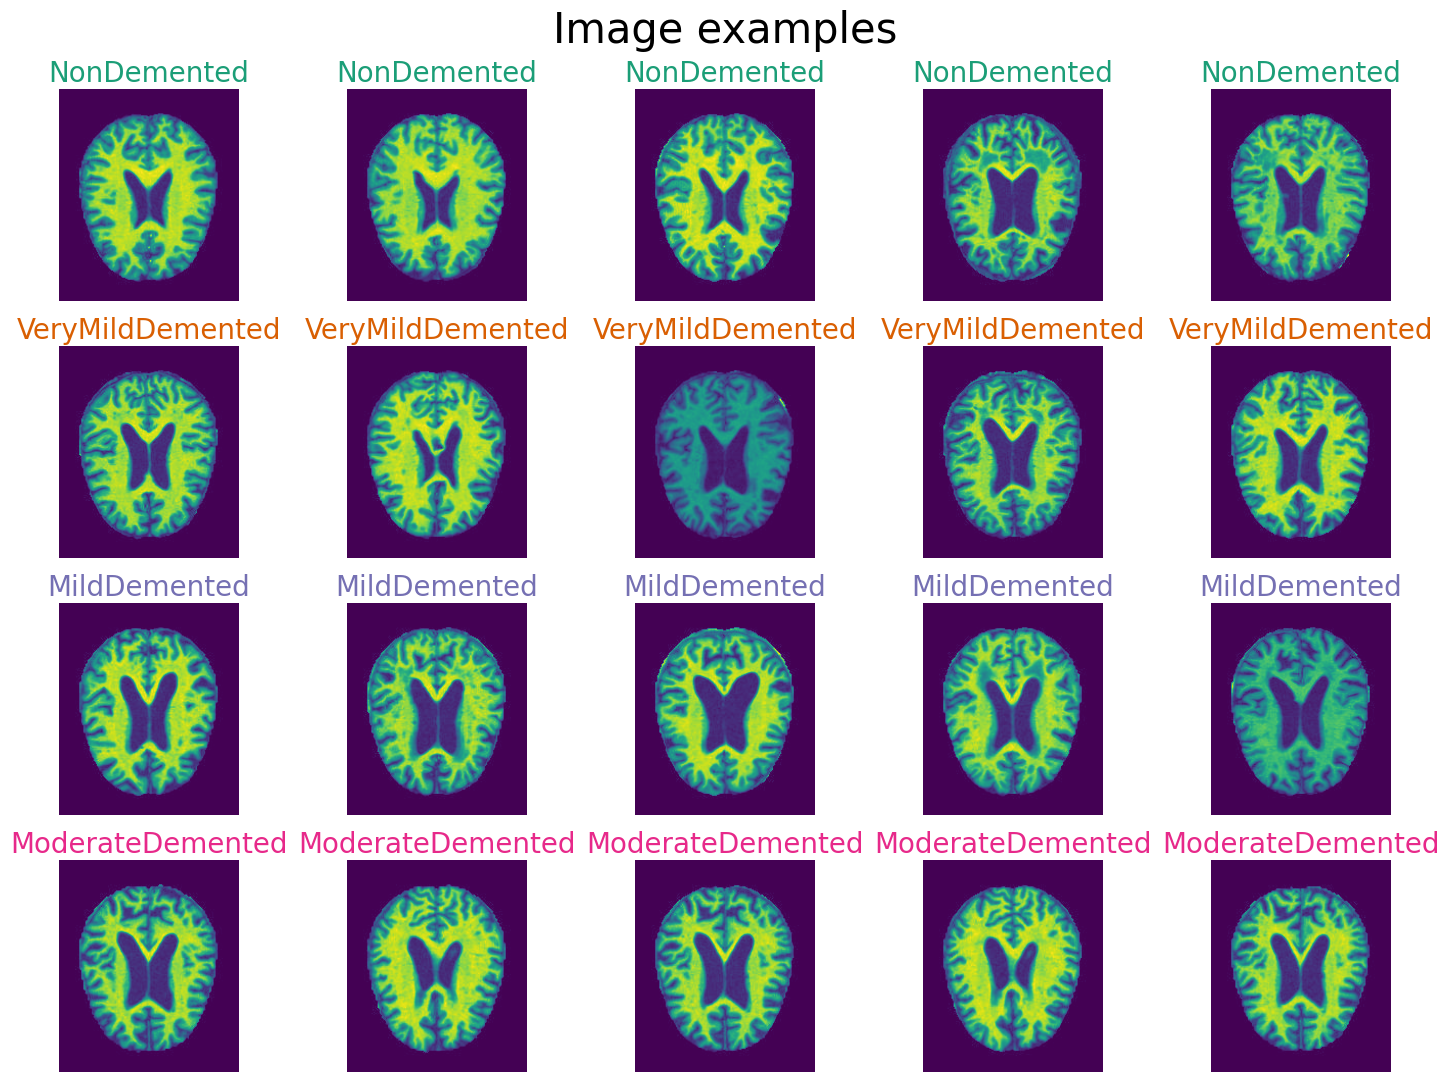

In [30]:
show_example_grid(alzheimer_test_path, alzheimer_classes)

## Creating the generators

We will now create the generators for the training, validation, and test datasets. The generators will load the images from the datasets and transform them into the format that the model can understand.

In [19]:
alzheimer_train_data, alzheimer_val_data, alzheimer_test_data = get_generators(alzheimer_train_path, alzheimer_test_path, resnet.preprocess_input, class_mode='categorical', augment_training_data=False)

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


## Creating the model

We will now create the model. The model will be a ResNet50 model that has been fine-tuned for the Alzheimer's classification task. The number of output classes will be set to the number of classes in the Alzheimer's dataset (4). We can take a look at the complex structure of the ResNet50 network, and it appears clearly that it would take weeks to of trial and errors to achieve such architecture, that's the benefit of doing transfer learning on proved solution.

In [ ]:
model = get_multiclass_transfer_model(ResNet50, len(alzheimer_classes))

94765736/94765736 [==============================] - 5s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

## Training the model

We will now train the model. The model will be trained for 10 epochs, and the validation dataset will be used to evaluate the model's performance. The model's weights will be saved after each epoch if the validation loss decreased.


In [ ]:
model_history = train_model(model, alzheimer_train_data, alzheimer_val_data, epochs=10, filepath='alzheimer_resnet.h5')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.31313, saving model to alzheimer_resnet.h5
956/956 - 120s - loss: 0.8569 - accuracy: 0.7307 - auc_7: 0.8747 - val_loss: 0.3131 - val_accuracy: 0.8705 - val_auc_7: 0.9521 - 120s/epoch - 125ms/step
Epoch 2/10

Epoch 2: val_loss did not improve from 0.31313
956/956 - 110s - loss: 0.4031 - accuracy: 0.8815 - auc_7: 0.9534 - val_loss: 0.3850 - val_accuracy: 0.8970 - val_auc_7: 0.9638 - 110s/epoch - 115ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.31313
956/956 - 111s - loss: 0.2781 - accuracy: 0.9267 - auc_7: 0.9741 - val_loss: 0.4662 - val_accuracy: 0.8832 - val_auc_7: 0.9501 - 111s/epoch - 116ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.31313
956/956 - 111s - loss: 0.2024 - accuracy: 0.9540 - auc_7: 0.9853 - val_loss: 0.8016 - val_accuracy: 0.8879 - val_auc_7: 0.9500 - 111s/epoch - 116ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.31313
956/956 - 120s - loss: 0.1971 - accuracy: 0.9582 - auc_7: 0.9850 - 

With a validation accurcay of 91% after 10 epochs, ResNet is a very serious candidate, althouh something is suspicious as the model start with a 0.87% validation accuracy and the loss although not bad is not great either.

We are going to try if VGG19 could also offer good results.

In [49]:
IMAGE_SHAPE = (176, 208)

In [50]:
alzheimer_train_data, alzheimer_val_data, alzheimer_test_data = get_generators(alzheimer_train_path, alzheimer_test_path, vgg19.preprocess_input, image_shape=IMAGE_SHAPE, class_mode='categorical', augment_training_data=False)

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [ ]:
model = get_multiclass_transfer_model(VGG19, len(alzheimer_classes), image_shape=IMAGE_SHAPE)

80134624/80134624 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                            

In [ ]:
model_history = train_model(model, alzheimer_train_data, alzheimer_val_data, epochs=5, filepath='alzheimer_vgg19.h5')

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.47362, saving model to alzheimer_vgg19.h5
956/956 - 140s - loss: 0.7712 - accuracy: 0.7313 - auc: 0.8759 - precision: 0.7333 - recall: 0.7302 - val_loss: 0.4736 - val_accuracy: 0.8134 - val_auc: 0.9231 - val_precision: 0.8145 - val_recall: 0.8117 - 140s/epoch - 147ms/step
Epoch 2/5

Epoch 2: val_loss did not improve from 0.47362
956/956 - 134s - loss: 0.4475 - accuracy: 0.8492 - auc: 0.9394 - precision: 0.8499 - recall: 0.8484 - val_loss: 0.5266 - val_accuracy: 0.8437 - val_auc: 0.9339 - val_precision: 0.8437 - val_recall: 0.8437 - 134s/epoch - 140ms/step
Epoch 3/5

Epoch 3: val_loss did not improve from 0.47362
956/956 - 130s - loss: 0.4494 - accuracy: 0.8672 - auc: 0.9453 - precision: 0.8678 - recall: 0.8669 - val_loss: 0.5887 - val_accuracy: 0.8340 - val_auc: 0.9246 - val_precision: 0.8340 - val_recall: 0.8337 - 130s/epoch - 136ms/step
Epoch 4/5

Epoch 4: val_loss did not improve from 0.47362
956/956 - 129s - loss: 0.4193 - accuracy: 0.8884 

Again some impressive number but a start very high in term of validation acuraccy.

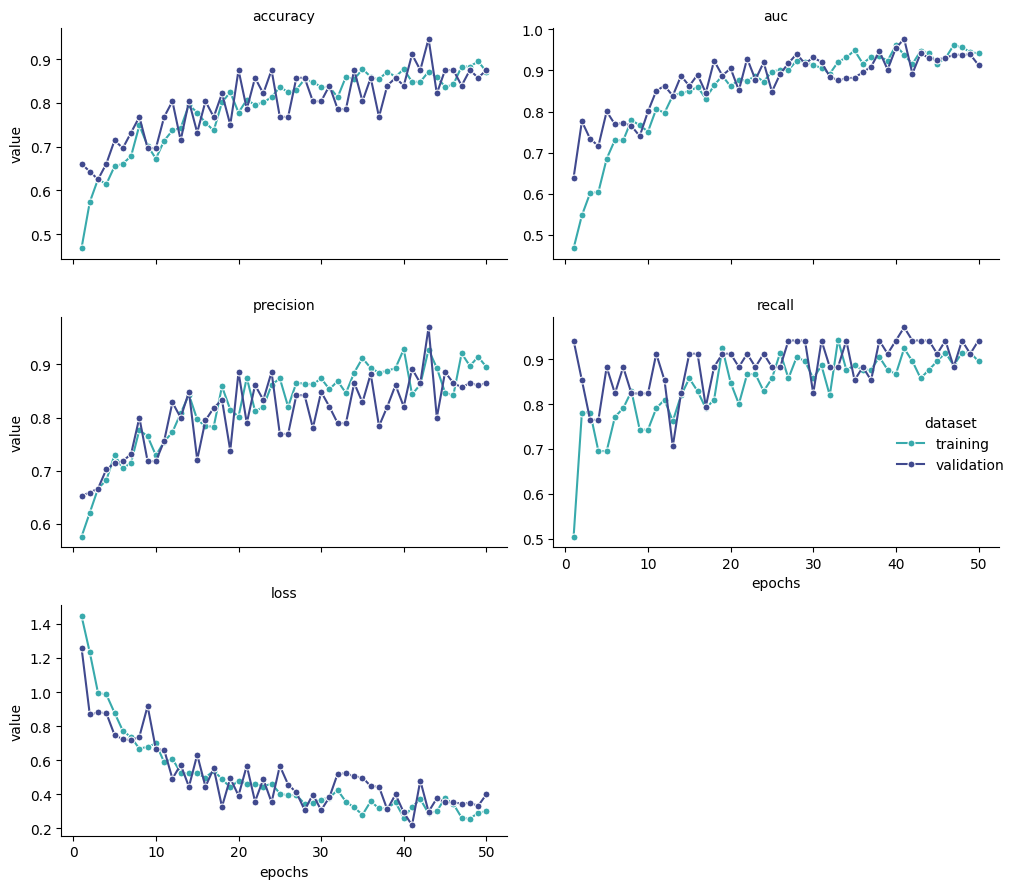

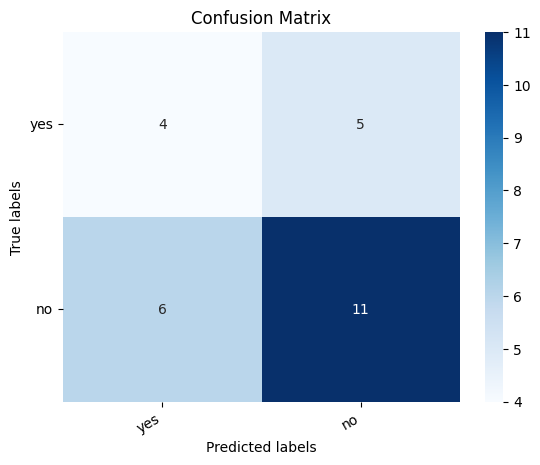

In [ ]:
plot_experiment_info(model_history, y_true, y_pred, brain_tumor_classes)

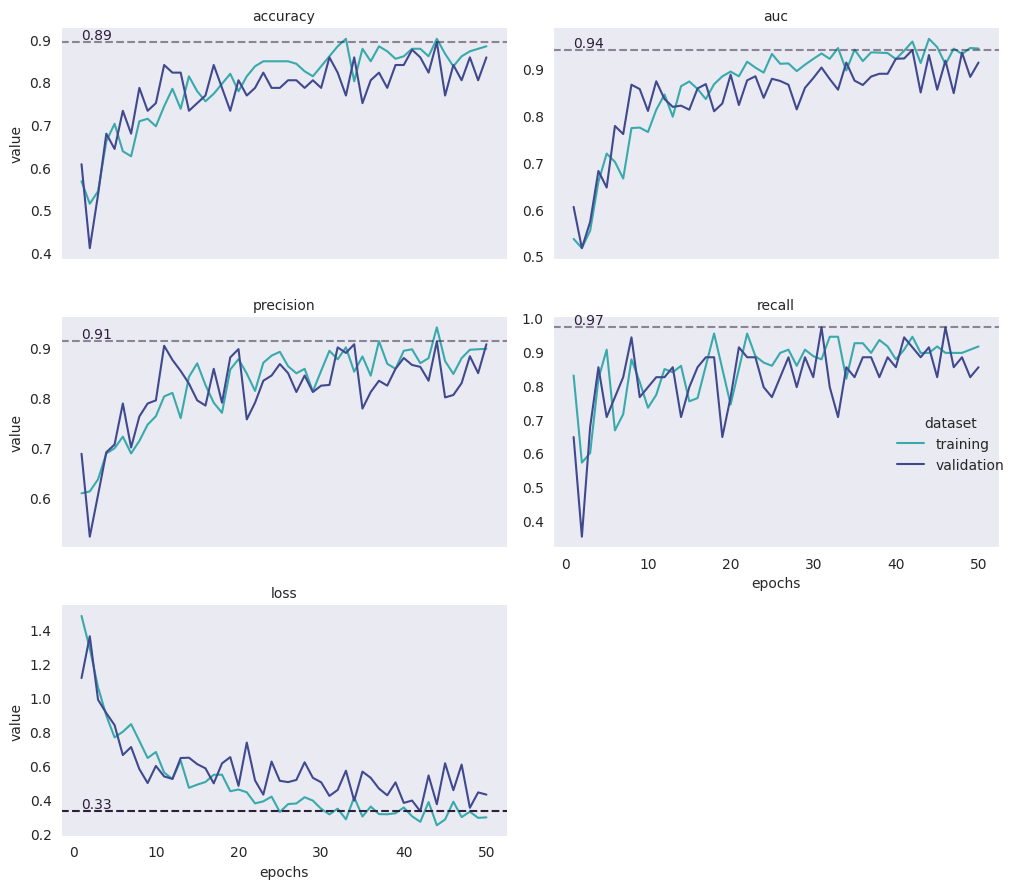

In [ ]:
plot_metrics_lines(model_history)

## Training pipeline
We are now going to go through the whole training pipeline with VGG19 and see what happens.

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
VGG19
80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4)                 2052  

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.38622, saving model to alzheimer_vgg19.h5
956/956 - 199s - loss: 0.7589 - accuracy: 0.4446 - auc: 0.6964 - precision: 0.4632 - recall: 0.3903 - val_loss: 0.3862 - val_accuracy: 0.6448 - val_auc: 0.8855 - val_precision: 0.7355 - val_recall: 0.5115 - 199s/epoch - 208ms/step
Epoch 2/150

Epoch 2: val_loss improved from 0.38622 to 0.38003, saving model to alzheimer_vgg19.h5
956/956 - 168s - loss: 0.4398 - accuracy: 0.5554 - auc: 0.8177 - precision: 0.6109 - recall: 0.4672 - val_loss: 0.3800 - val_accuracy: 0.6775 - val_auc: 0.8995 - val_precision: 0.7612 - val_recall: 0.5262 - 168s/epoch - 176ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.38003 to 0.36953, saving model to alzheimer_vgg19.h5
956/956 - 167s - loss: 0.4335 - accuracy: 0.5626 - auc: 0.8240 - precision: 0.6143 - recall: 0.4821 - val_loss: 0.3695 - val_accuracy: 0.6427 - val_auc: 0.8838 - val_precision: 0.7167 - val_recall: 0.5533 - 167s/epoch - 175ms/step
Epoch 4/150

Epoch 4: v

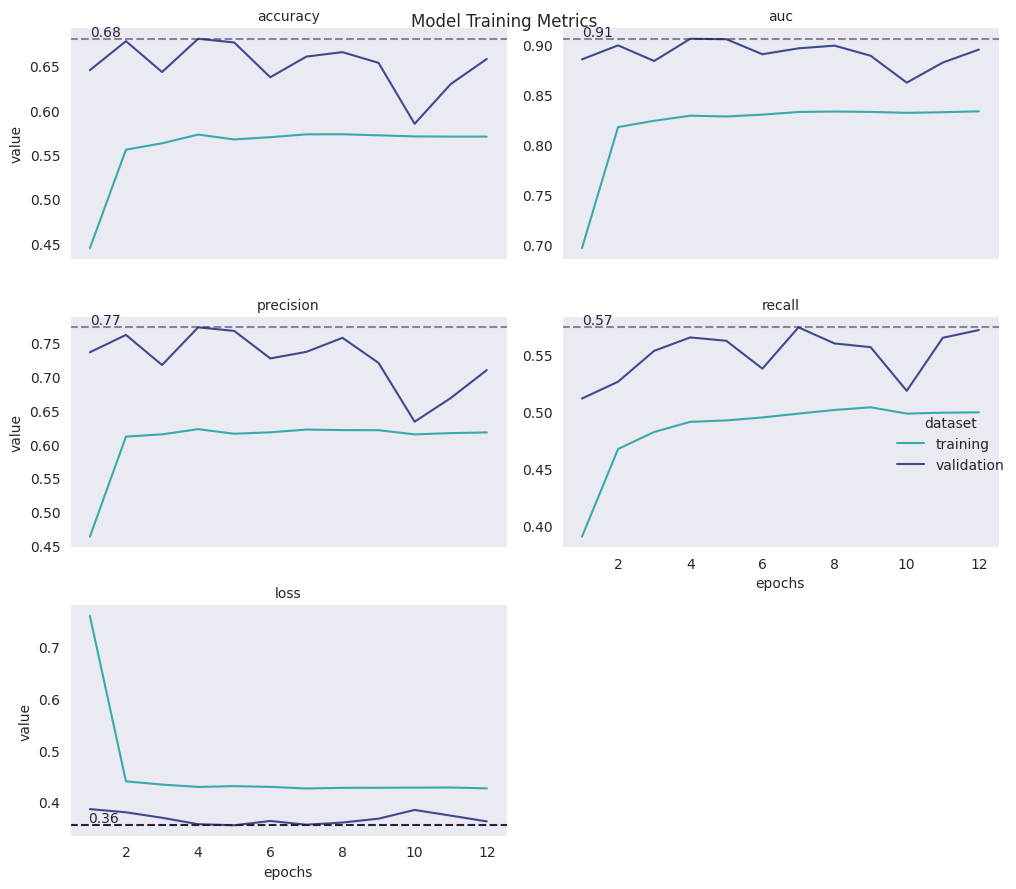

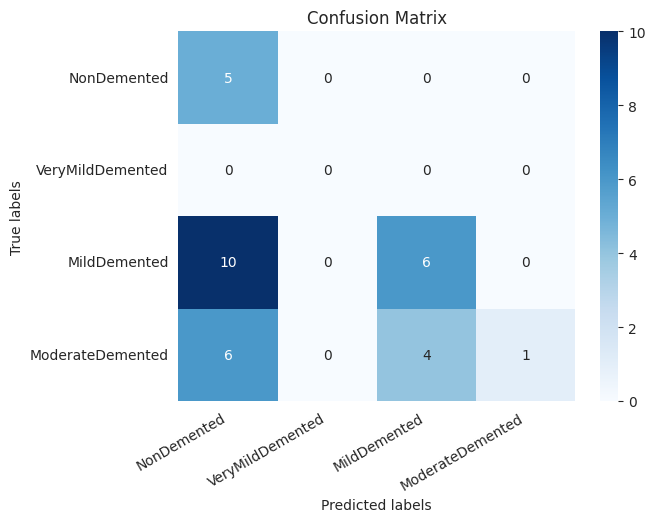

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 20,026,436
Trainable params: 20,026,436
Non-trainable params: 0
_________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.16586, saving model to alzheimer_vgg19_unfrozen.h5
956/956 - 521s - loss: 0.2838 - accuracy: 0.7388 - auc: 0.9134 - precision: 0.7337 - recall: 0.6479 - val_loss: 0.1659 - val_accuracy: 0.8882 - val_auc: 0.9852 - val_precision: 0.9100 - val_recall: 0.8687 - 521s/epoch - 545ms/step
Epoch 2/50


In [ ]:
trained_model, model_history = run_training_pipeline(VGG19, alzheimer_train_path, alzheimer_test_path, classes=alzheimer_classes, model_name="alzheimer_vgg19", frozen_epochs=150, unfrozen_epochs=50, validation_split=0.1, augment_training_data=False, plot_results=True, patience=5, image_shape=(176, 208))

# Stroke

## Splitting the data

We split the data into training and test sets and organise the folders with their paths. The test set will be 5% of the data, and the training set will be the rest of the data.


In [56]:
stroke_dir = join(root_dir, "stroke", "Brain_Data_Organised")
stroke_train_path = join(stroke_dir, 'train')
stroke_test_path = join(stroke_dir, 'test')
stroke_classes = ['Normal', 'Stroke']

split_train_test_data(images_dir=stroke_dir, classes=stroke_classes, test_ratio=0.05)

## Visualizing the data split

We can visualize the data split by plotting the number of images in each class in the training and test sets.

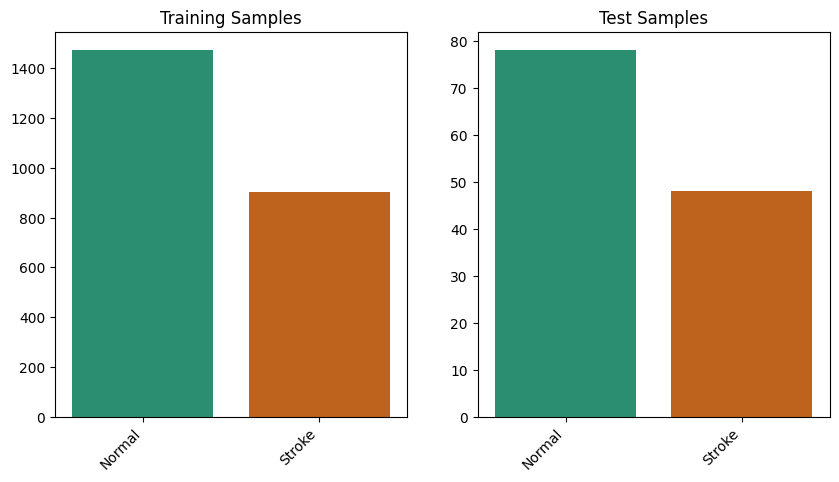

In [34]:
plot_dataset_balance(stroke_train_path, stroke_test_path, stroke_classes)

## Visualizing some example images

We can also visualize some example images from the training set. This will help us to get a better understanding of the data.

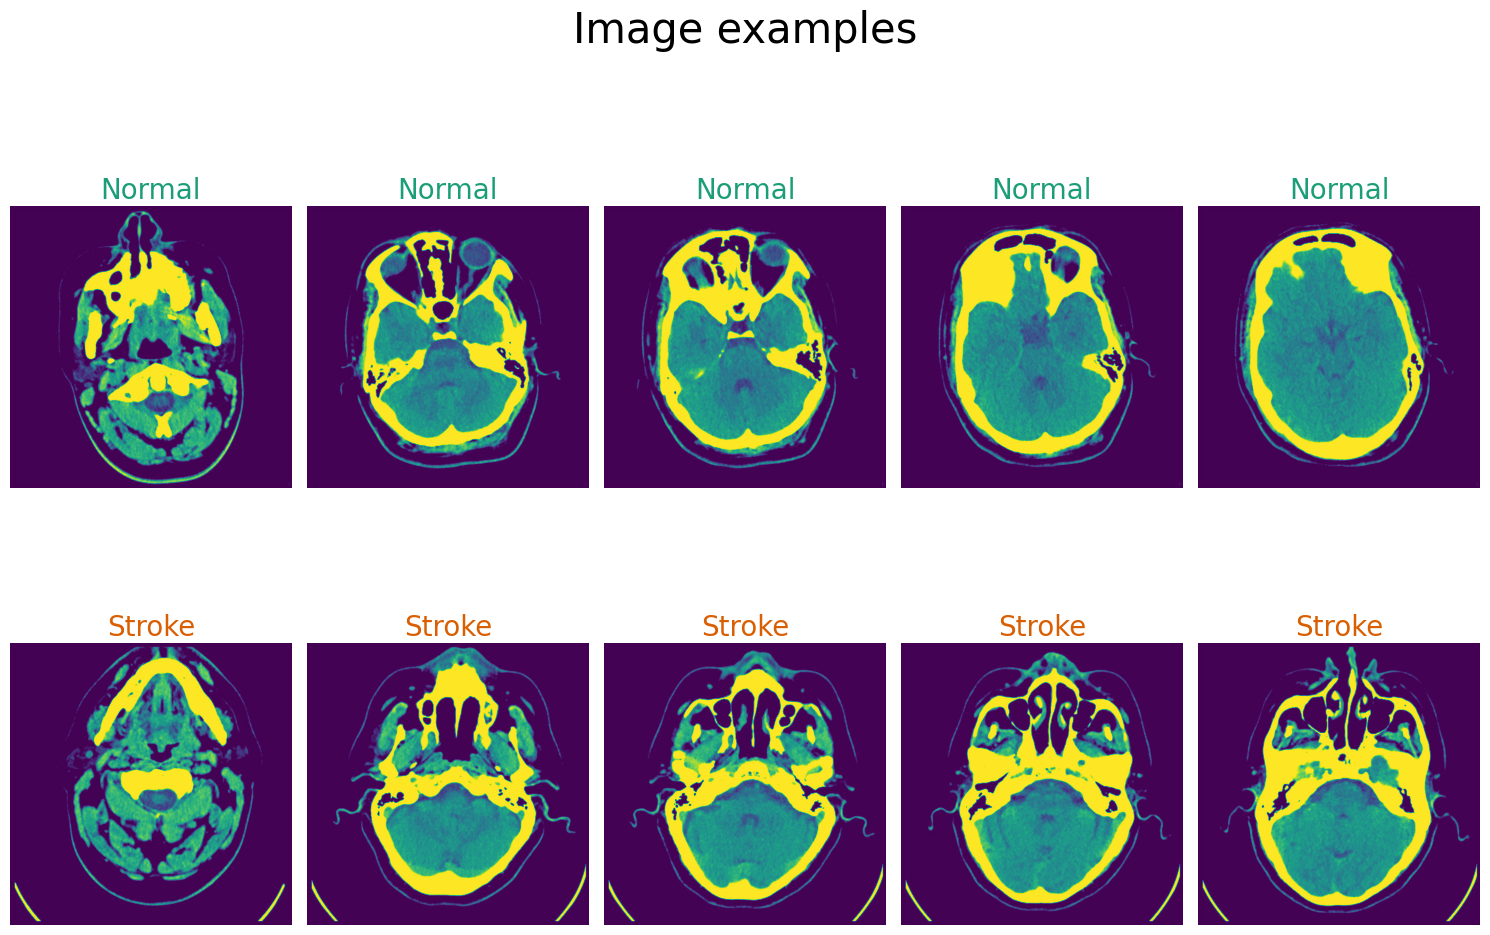

In [35]:
show_example_grid(stroke_train_path, stroke_classes)

## Models Comparison
To select the best model to tackle this task we can using the `compare_models` pipeline. It accepts a list of models as argument but if none are given it will use the 12 models listed above. We run them for 10 epochs to get a good idea of which one is promising while not training for too much time.

In [ ]:
trained_models, results = compare_models(stroke_train_path, stroke_test_path, epochs=10)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params:

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 38s - loss: 0.6765 - accuracy: 0.6145 - auc: 0.5799 - precision: 0.4869 - recall: 0.2747 - val_loss: 0.6821 - val_accuracy: 0.6155 - val_auc: 0.5667 - val_precision: 0.4571 - val_recall: 0.0711 - 38s/epoch - 671ms/step
Epoch 2/10
56/56 - 12s - loss: 0.6022 - accuracy: 0.6633 - auc: 0.7008 - precision: 0.5881 - recall: 0.3796 - val_loss: 0.6590 - val_accuracy: 0.6358 - val_auc: 0.6055 - val_precision: 0.5306 - val_recall: 0.3467 - 12s/epoch - 209ms/step
Epoch 3/10
56/56 - 10s - loss: 0.5704 - accuracy: 0.6987 - auc: 0.7504 - precision: 0.6483 - recall: 0.4520 - val_loss: 0.6891 - val_accuracy: 0.6239 - val_auc: 0.6224 - val_precision: 0.5312 - val_recall: 0.0756 - 10s/epoch - 180ms/step
Epoch 4/10
56/56 - 9s - loss: 0.5301 - accuracy: 0.7329 - auc: 0.8024 - precision: 0.7107 - recall: 0.5007 - val_loss: 0.6720 - val_accuracy: 0.6239 - val_auc: 0.6320 - val_precision: 0.5185 - val_recall: 0.1244 - 9s/epoch - 160ms/step
Epoch 5/10
56/56 - 10s - loss: 0.5040 - accuracy: 0.7604 - au

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 24s - loss: 1.4608 - accuracy: 0.5398 - auc: 0.5234 - precision: 0.4170 - recall: 0.3537 - val_loss: 1.0854 - val_accuracy: 0.5464 - val_auc: 0.5244 - val_precision: 0.3675 - val_recall: 0.2711 - 24s/epoch - 424ms/step
Epoch 2/10
56/56 - 11s - loss: 0.9456 - accuracy: 0.5791 - auc: 0.5602 - precision: 0.4408 - recall: 0.4018 - val_loss: 0.9452 - val_accuracy: 0.5750 - val_auc: 0.5629 - val_precision: 0.4056 - val_recall: 0.2578 - 11s/epoch - 191ms/step
Epoch 3/10
56/56 - 10s - loss: 0.8141 - accuracy: 0.6156 - auc: 0.6167 - precision: 0.4934 - recall: 0.4402 - val_loss: 0.8706 - val_accuracy: 0.5987 - val_auc: 0.5891 - val_precision: 0.4539 - val_recall: 0.2844 - 10s/epoch - 181ms/step
Epoch 4/10
56/56 - 10s - loss: 0.7303 - accuracy: 0.6369 - auc: 0.6646 - precision: 0.5245 - recall: 0.4742 - val_loss: 0.8529 - val_accuracy: 0.6324 - val_auc: 0.6151 - val_precision: 0.5294 - val_recall: 0.2800 - 10s/epoch - 186ms/step
Epoch 5/10
56/56 - 10s - loss: 0.6672 - accuracy: 0.6566 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 14s - loss: 1.1619 - accuracy: 0.5438 - auc: 0.5382 - precision: 0.4175 - recall: 0.3703 - val_loss: 1.0308 - val_accuracy: 0.5363 - val_auc: 0.5020 - val_precision: 0.3904 - val_recall: 0.3956 - 14s/epoch - 246ms/step
Epoch 2/10
56/56 - 12s - loss: 0.8589 - accuracy: 0.6027 - auc: 0.5896 - precision: 0.4736 - recall: 0.4106 - val_loss: 0.8914 - val_accuracy: 0.5868 - val_auc: 0.5532 - val_precision: 0.4533 - val_recall: 0.4311 - 12s/epoch - 218ms/step
Epoch 3/10
56/56 - 12s - loss: 0.7403 - accuracy: 0.6414 - auc: 0.6536 - precision: 0.5316 - recall: 0.4727 - val_loss: 0.8610 - val_accuracy: 0.6172 - val_auc: 0.5867 - val_precision: 0.4915 - val_recall: 0.2578 - 12s/epoch - 221ms/step
Epoch 4/10
56/56 - 12s - loss: 0.6665 - accuracy: 0.6700 - auc: 0.6984 - precision: 0.5769 - recall: 0.4934 - val_loss: 0.7764 - val_accuracy: 0.6239 - val_auc: 0.6237 - val_precision: 0.5052 - val_recall: 0.4311 - 12s/epoch - 217ms/step
Epoch 5/10
56/56 - 12s - loss: 0.6065 - accuracy: 0.7009 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 20s - loss: 1.0509 - accuracy: 0.5814 - auc: 0.5841 - precision: 0.4699 - recall: 0.3891 - val_loss: 1.3013 - val_accuracy: 0.4722 - val_auc: 0.4463 - val_precision: 0.3053 - val_recall: 0.3067 - 20s/epoch - 358ms/step
Epoch 2/10
56/56 - 11s - loss: 0.7333 - accuracy: 0.6481 - auc: 0.6628 - precision: 0.5421 - recall: 0.4756 - val_loss: 0.8827 - val_accuracy: 0.6088 - val_auc: 0.5854 - val_precision: 0.4667 - val_recall: 0.2178 - 11s/epoch - 203ms/step
Epoch 3/10
56/56 - 11s - loss: 0.6521 - accuracy: 0.6835 - auc: 0.7241 - precision: 0.5898 - recall: 0.5480 - val_loss: 0.8413 - val_accuracy: 0.5919 - val_auc: 0.5960 - val_precision: 0.4619 - val_recall: 0.4578 - 11s/epoch - 197ms/step
Epoch 4/10
56/56 - 11s - loss: 0.5499 - accuracy: 0.7222 - auc: 0.7855 - precision: 0.6487 - recall: 0.5864 - val_loss: 0.7650 - val_accuracy: 0.6003 - val_auc: 0.6327 - val_precision: 0.4717 - val_recall: 0.4444 - 11s/epoch - 195ms/step
Epoch 5/10
56/56 - 13s - loss: 0.4791 - accuracy: 0.7654 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
56/56 - 20s - loss: 2.1463 - accuracy: 0.5539 - auc: 0.5442 - precision: 0.4384 - recall: 0.4257 - val_loss: 1.5229 - val_accuracy: 0.5379 - val_auc: 0.6212 - val_precision: 0.4294 - val_recall: 0.6622 - 20s/epoch - 358ms/step
Epoch 2/10
56/56 - 9s - loss: 1.3992 - accuracy: 0.5909 - auc: 0.5908 - precision: 0.4605 - recall: 0.4476 - val_loss: 1.4050 - val_accuracy: 0.5970 - val_auc: 0.5792 - val_precision: 0.4615 - val_recall: 0.3733 - 9s/epoch - 152ms/step
Epoch 3/10
56/56 - 9s - loss: 1.3212 - accuracy: 0.6122 - auc: 0.6322 - precision: 0.4891 - recall: 0.4638 - val_loss: 1.2698 - val_accuracy: 0.5885 - val_auc: 0.6234 - val_precision: 0.4664 - val_recall: 0.5867 - 9s/epoch - 153ms/step
Epoch 4/10
56/56 - 8s - loss: 1.1100 - accuracy: 0.6414 - auc: 0.6711 - precision: 0.5288 - recall: 0.5155 - val_loss: 1.3752 - val_accuracy: 0.5717 - val_auc: 0.6359 - val_precision: 0.4540 - val_recall: 0.6356 - 8s/epoch - 139ms/step
Epoch 5/10
56/56 - 9s - loss: 1.0419 - accuracy: 0.662

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 32s - loss: 16.5266 - accuracy: 0.5202 - auc: 0.5023 - precision: 0.3895 - recall: 0.3714 - val_loss: 7.9271 - val_accuracy: 0.6223 - val_auc: 0.5128 - val_precision: 0.5556 - val_recall: 0.0222 - 32s/epoch - 563ms/step
Epoch 2/10
56/56 - 13s - loss: 3.8477 - accuracy: 0.5348 - auc: 0.4964 - precision: 0.3824 - recall: 0.3648 - val_loss: 5.2802 - val_accuracy: 0.3457 - val_auc: 0.3890 - val_precision: 0.3558 - val_recall: 0.8933 - 13s/epoch - 230ms/step
Epoch 3/10
56/56 - 13s - loss: 11.3929 - accuracy: 0.5505 - auc: 0.5289 - precision: 0.4119 - recall: 0.4284 - val_loss: 14.5526 - val_accuracy: 0.6206 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 13s/epoch - 232ms/step
Epoch 4/10
56/56 - 13s - loss: 7.2426 - accuracy: 0.5359 - auc: 0.5070 - precision: 0.3900 - recall: 0.3929 - val_loss: 10.5751 - val_accuracy: 0.6206 - val_auc: 0.5022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 13s/epoch - 230ms/step
Epoch 5/10
56/56 - 13s - loss: 8.2341 -

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 12s - loss: 0.6620 - accuracy: 0.6021 - auc: 0.5325 - precision: 0.4310 - recall: 0.1696 - val_loss: 0.6667 - val_accuracy: 0.6358 - val_auc: 0.6465 - val_precision: 0.8462 - val_recall: 0.0489 - 12s/epoch - 207ms/step
Epoch 2/10
56/56 - 7s - loss: 0.6072 - accuracy: 0.6554 - auc: 0.6896 - precision: 0.5963 - recall: 0.2880 - val_loss: 0.6462 - val_accuracy: 0.6509 - val_auc: 0.6208 - val_precision: 0.6552 - val_recall: 0.1689 - 7s/epoch - 125ms/step
Epoch 3/10
56/56 - 8s - loss: 0.5665 - accuracy: 0.6992 - auc: 0.7747 - precision: 0.6870 - recall: 0.3826 - val_loss: 0.6733 - val_accuracy: 0.6644 - val_auc: 0.6191 - val_precision: 0.8250 - val_recall: 0.1467 - 8s/epoch - 139ms/step
Epoch 4/10
56/56 - 8s - loss: 0.5478 - accuracy: 0.7177 - auc: 0.7958 - precision: 0.7231 - recall: 0.4165 - val_loss: 0.6245 - val_accuracy: 0.6644 - val_auc: 0.6513 - val_precision: 0.6300 - val_recall: 0.2800 - 8s/epoch - 141ms/step
Epoch 5/10
56/56 - 7s - loss: 0.5238 - accuracy: 0.7480 - auc: 0.

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
56/56 - 26s - loss: 2.1155 - accuracy: 0.5045 - auc: 0.5000 - precision: 0.3806 - recall: 0.3215 - val_loss: 1.1753 - val_accuracy: 0.5194 - val_auc: 0.3941 - val_precision: 0.2619 - val_recall: 0.1467 - 26s/epoch - 459ms/step
Epoch 2/10
56/56 - 8s - loss: 0.8723 - accuracy: 0.5584 - auc: 0.5358 - precision: 0.4032 - recall: 0.3383 - val_loss: 1.0701 - val_accuracy: 0.5497 - val_auc: 0.4342 - val_precision: 0.2981 - val_recall: 0.1378 - 8s/epoch - 152ms/step
Epoch 3/10
56/56 - 11s - loss: 0.7666 - accuracy: 0.5909 - auc: 0.5900 - precision: 0.4549 - recall: 0.3870 - val_loss: 1.0003 - val_accuracy: 0.5261 - val_auc: 0.4342 - val_precision: 0.3586 - val_recall: 0.3156 - 11s/epoch - 192ms/step
Epoch 4/10
56/56 - 9s - loss: 0.7180 - accuracy: 0.6279 - auc: 0.6305 - precision: 0.5124 - recall: 0.4269 - val_loss: 0.9681 - val_accuracy: 0.5565 - val_auc: 0.4521 - val_precision: 0.3643 - val_recall: 0.2267 - 9s/epoch - 164ms/step
Epoch 5/10
56/56 - 9s - loss: 0.6772 - accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 25s - loss: 1.4717 - accuracy: 0.5180 - auc: 0.4712 - precision: 0.3523 - recall: 0.3426 - val_loss: 0.6771 - val_accuracy: 0.6695 - val_auc: 0.6796 - val_precision: 0.5848 - val_recall: 0.4444 - 25s/epoch - 443ms/step
Epoch 2/10
56/56 - 10s - loss: 0.7882 - accuracy: 0.6061 - auc: 0.5990 - precision: 0.4787 - recall: 0.4151 - val_loss: 0.7499 - val_accuracy: 0.6408 - val_auc: 0.6243 - val_precision: 0.5652 - val_recall: 0.2311 - 10s/epoch - 174ms/step
Epoch 3/10
56/56 - 10s - loss: 0.6806 - accuracy: 0.6504 - auc: 0.6805 - precision: 0.5453 - recall: 0.4801 - val_loss: 1.1661 - val_accuracy: 0.6290 - val_auc: 0.6085 - val_precision: 0.7778 - val_recall: 0.0311 - 10s/epoch - 178ms/step
Epoch 4/10
56/56 - 10s - loss: 0.6011 - accuracy: 0.6942 - auc: 0.7423 - precision: 0.6154 - recall: 0.5199 - val_loss: 0.7644 - val_accuracy: 0.6391 - val_auc: 0.5852 - val_precision: 0.5447 - val_recall: 0.2978 - 10s/epoch - 173ms/step
Epoch 5/10
56/56 - 12s - loss: 0.5224 - accuracy: 0.7357 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 31s - loss: 0.9460 - accuracy: 0.5421 - auc: 0.5319 - precision: 0.3975 - recall: 0.3592 - val_loss: 1.0418 - val_accuracy: 0.4890 - val_auc: 0.5503 - val_precision: 0.4141 - val_recall: 0.8356 - 31s/epoch - 553ms/step
Epoch 2/10
56/56 - 12s - loss: 0.7931 - accuracy: 0.5937 - auc: 0.5793 - precision: 0.4613 - recall: 0.4136 - val_loss: 0.7420 - val_accuracy: 0.5784 - val_auc: 0.6148 - val_precision: 0.4138 - val_recall: 0.2667 - 12s/epoch - 210ms/step
Epoch 3/10
56/56 - 12s - loss: 0.6787 - accuracy: 0.6420 - auc: 0.6429 - precision: 0.5369 - recall: 0.4195 - val_loss: 0.6969 - val_accuracy: 0.6239 - val_auc: 0.6395 - val_precision: 0.5053 - val_recall: 0.4267 - 12s/epoch - 206ms/step
Epoch 4/10
56/56 - 12s - loss: 0.6264 - accuracy: 0.6762 - auc: 0.6993 - precision: 0.5865 - recall: 0.5007 - val_loss: 0.6795 - val_accuracy: 0.6256 - val_auc: 0.6589 - val_precision: 0.5099 - val_recall: 0.3422 - 12s/epoch - 207ms/step
Epoch 5/10
56/56 - 12s - loss: 0.6279 - accuracy: 0.6745 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
56/56 - 29s - loss: 0.7821 - accuracy: 0.5460 - auc: 0.5467 - precision: 0.4159 - recall: 0.2960 - val_loss: 0.6500 - val_accuracy: 0.6121 - val_auc: 0.6317 - val_precision: 0.4855 - val_recall: 0.3733 - 29s/epoch - 526ms/step
Epoch 2/10
56/56 - 10s - loss: 0.6779 - accuracy: 0.6010 - auc: 0.5693 - precision: 0.4614 - recall: 0.2999 - val_loss: 0.6312 - val_accuracy: 0.6374 - val_auc: 0.6472 - val_precision: 0.5806 - val_recall: 0.1600 - 10s/epoch - 173ms/step
Epoch 3/10
56/56 - 9s - loss: 0.6470 - accuracy: 0.6274 - auc: 0.6090 - precision: 0.5206 - recall: 0.2422 - val_loss: 0.6508 - val_accuracy: 0.6459 - val_auc: 0.5986 - val_precision: 0.5926 - val_recall: 0.2133 - 9s/epoch - 155ms/step
Epoch 4/10
56/56 - 8s - loss: 0.6277 - accuracy: 0.6470 - auc: 0.6512 - precision: 0.5667 - recall: 0.3013 - val_loss: 0.6671 - val_accuracy: 0.5835 - val_auc: 0.5769 - val_precision: 0.4329 - val_recall: 0.3156 - 8s/epoch - 139ms/step
Epoch 5/10
56/56 - 8s - loss: 0.6146 - accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 58s - loss: 0.7418 - accuracy: 0.5707 - auc: 0.5283 - precision: 0.3961 - recall: 0.2051 - val_loss: 0.7724 - val_accuracy: 0.6189 - val_auc: 0.5585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 58s/epoch - 1s/step
Epoch 2/10
56/56 - 28s - loss: 0.6418 - accuracy: 0.6380 - auc: 0.6465 - precision: 0.5381 - recall: 0.3338 - val_loss: 0.7086 - val_accuracy: 0.5953 - val_auc: 0.5413 - val_precision: 0.3333 - val_recall: 0.0667 - 28s/epoch - 505ms/step
Epoch 3/10
56/56 - 28s - loss: 0.5956 - accuracy: 0.6807 - auc: 0.7079 - precision: 0.6324 - recall: 0.3811 - val_loss: 0.7325 - val_accuracy: 0.5363 - val_auc: 0.5410 - val_precision: 0.4132 - val_recall: 0.5289 - 28s/epoch - 509ms/step
Epoch 4/10
56/56 - 29s - loss: 0.5693 - accuracy: 0.7009 - auc: 0.7539 - precision: 0.6629 - recall: 0.4328 - val_loss: 0.7364 - val_accuracy: 0.5514 - val_auc: 0.5217 - val_precision: 0.3727 - val_recall: 0.2667 - 29s/epoch - 512ms/step
Epoch 5/10
56/56 - 28s - loss: 0.5469 - accuracy: 0.73

## Results Visualization

Results are not that easy to compare in text format, we could create a table with epocs as index, but we can do even better by plotting the actual training of models over epochs, knowing that all models are compared using the same data and same epochs.

Xception give very good training results but not beat other models in validation, which means that it tends to overfit. This can probably be avoided but for now we are going to bet on the best validation models. DenseNet169, VGG19 and InceptionRestNetV2 are the most interesting. We can inspect the performance of these models more in depth over additional epochs, by passing those to the `compare_models` function.

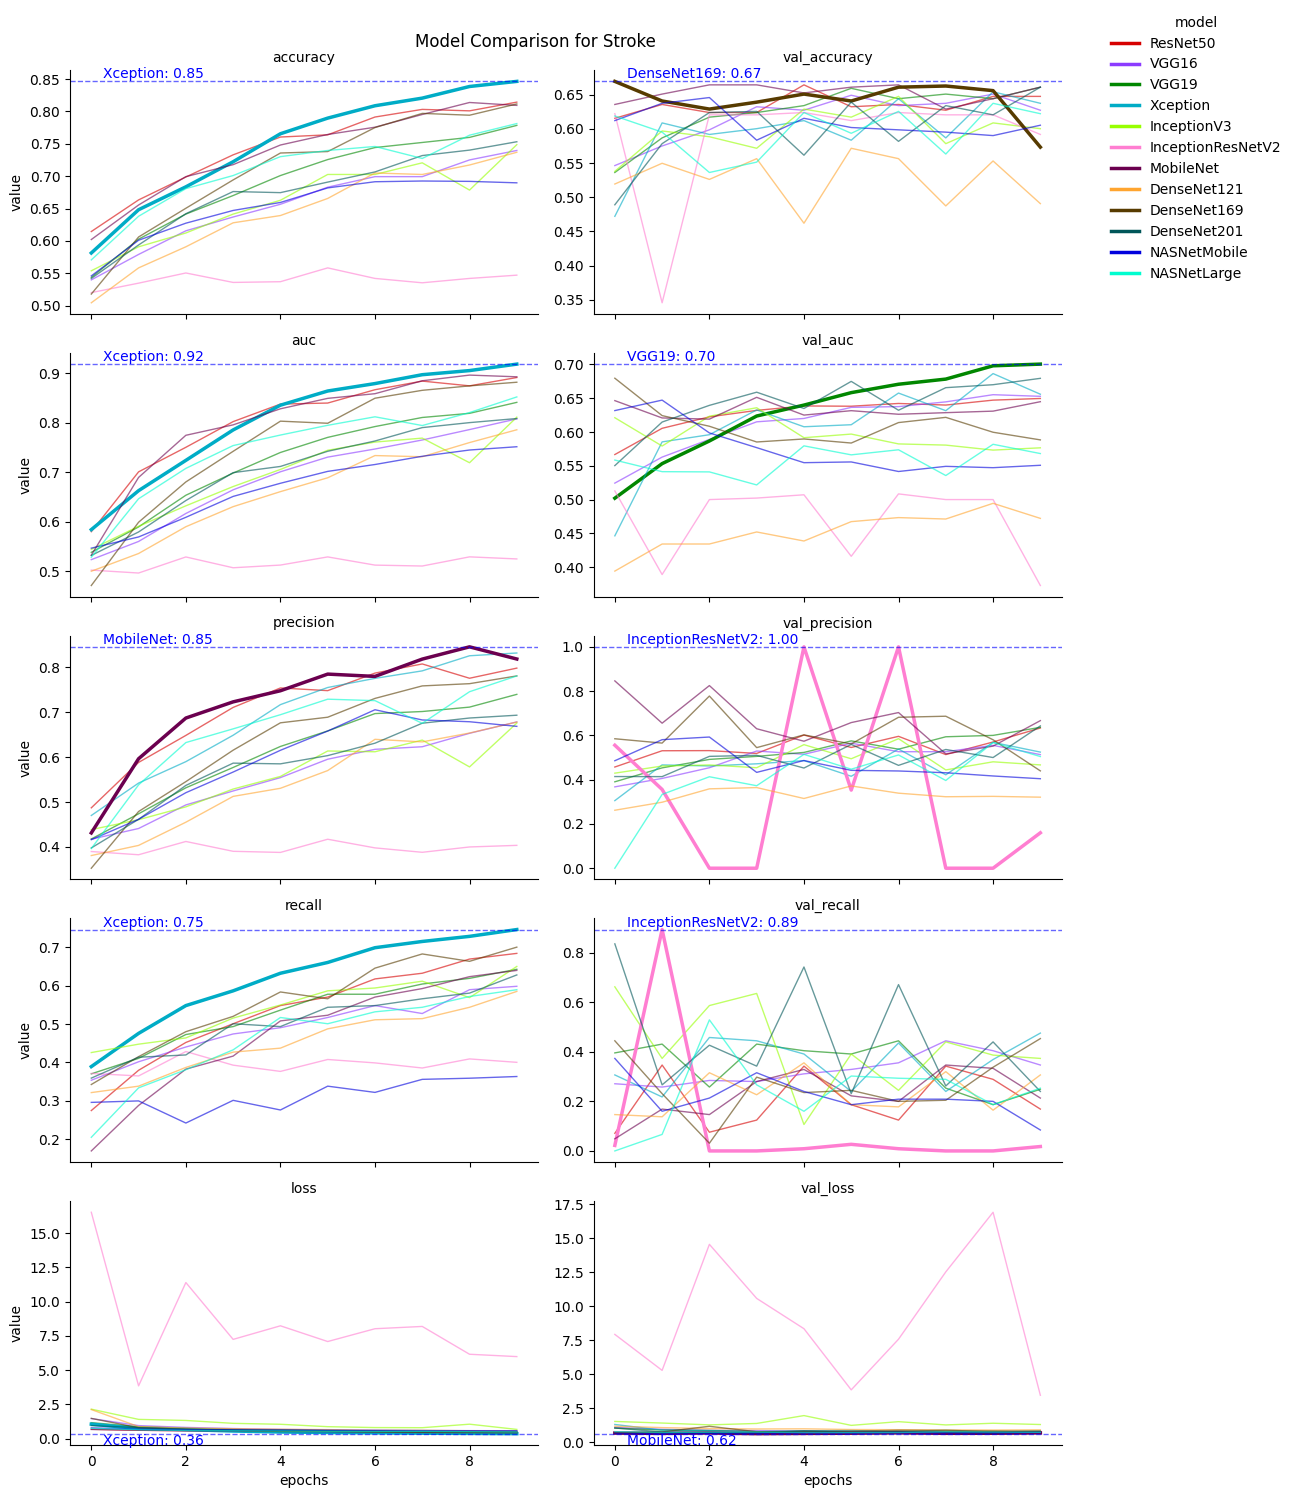

In [ ]:
plot_models_comparison(results, 'Stroke')

In [ ]:
results.to_csv('stroke_model_comparison.csv')

Let's run those 3 models for 20 epochs if they keep on training and converging well.

In [ ]:
trained_models, results = compare_models(stroke_train_path, stroke_test_path, models=[DenseNet169, VGG19, InceptionResNetV2], epochs=20)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_12  (None, 1664)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
__________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
56/56 - 26s - loss: 1.4455 - accuracy: 0.5477 - auc: 0.5262 - precision: 0.4130 - recall: 0.3370 - val_loss: 0.7574 - val_accuracy: 0.6189 - val_auc: 0.6254 - val_precision: 0.4973 - val_recall: 0.4133 - 26s/epoch - 471ms/step
Epoch 2/20
56/56 - 11s - loss: 0.7758 - accuracy: 0.6061 - auc: 0.6291 - precision: 0.4799 - recall: 0.4417 - val_loss: 0.9049 - val_accuracy: 0.6341 - val_auc: 0.6328 - val_precision: 0.6176 - val_recall: 0.0933 - 11s/epoch - 201ms/step
Epoch 3/20
56/56 - 10s - loss: 0.6909 - accuracy: 0.6425 - auc: 0.6884 - precision: 0.5355 - recall: 0.4461 - val_loss: 0.7459 - val_accuracy: 0.6172 - val_auc: 0.6280 - val_precision: 0.4922 - val_recall: 0.2800 - 10s/epoch - 176ms/step
Epoch 4/20
56/56 - 9s - loss: 0.5854 - accuracy: 0.7015 - auc: 0.7553 - precision: 0.6198 - recall: 0.5539 - val_loss: 0.7349 - val_accuracy: 0.6391 - val_auc: 0.6574 - val_precision: 0.5534 - val_recall: 0.2533 - 9s/epoch - 164ms/step
Epoch 5/20
56/56 - 10s - loss: 0.5628 - accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 14s - loss: 1.3247 - accuracy: 0.5533 - auc: 0.5522 - precision: 0.4515 - recall: 0.3869 - val_loss: 1.1340 - val_accuracy: 0.5835 - val_auc: 0.5103 - val_precision: 0.4247 - val_recall: 0.2756 - 14s/epoch - 248ms/step
Epoch 2/20
56/56 - 12s - loss: 0.9734 - accuracy: 0.5831 - auc: 0.5710 - precision: 0.4464 - recall: 0.4062 - val_loss: 1.0160 - val_accuracy: 0.5750 - val_auc: 0.5221 - val_precision: 0.4301 - val_recall: 0.3689 - 12s/epoch - 219ms/step
Epoch 3/20
56/56 - 12s - loss: 0.8201 - accuracy: 0.6162 - auc: 0.6229 - precision: 0.4941 - recall: 0.4328 - val_loss: 0.9576 - val_accuracy: 0.5919 - val_auc: 0.5633 - val_precision: 0.4298 - val_recall: 0.2311 - 12s/epoch - 219ms/step
Epoch 4/20
56/56 - 12s - loss: 0.7203 - accuracy: 0.6364 - auc: 0.6687 - precision: 0.5241 - recall: 0.4653 - val_loss: 0.8555 - val_accuracy: 0.5953 - val_auc: 0.5915 - val_precision: 0.4566 - val_recall: 0.3511 - 12s/epoch - 213ms/step
Epoch 5/20
56/56 - 12s - loss: 0.6744 - accuracy: 0.6633 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 29s - loss: 22.0000 - accuracy: 0.5393 - auc: 0.5270 - precision: 0.4359 - recall: 0.4224 - val_loss: 8.6240 - val_accuracy: 0.6155 - val_auc: 0.5200 - val_precision: 0.2857 - val_recall: 0.0089 - 29s/epoch - 511ms/step
Epoch 2/20
56/56 - 13s - loss: 7.0870 - accuracy: 0.5432 - auc: 0.5126 - precision: 0.3967 - recall: 0.3885 - val_loss: 17.7636 - val_accuracy: 0.6206 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 13s/epoch - 232ms/step
Epoch 3/20
56/56 - 13s - loss: 11.9428 - accuracy: 0.5253 - auc: 0.4993 - precision: 0.3729 - recall: 0.3663 - val_loss: 36.6546 - val_accuracy: 0.3794 - val_auc: 0.5000 - val_precision: 0.3794 - val_recall: 1.0000 - 13s/epoch - 232ms/step
Epoch 4/20
56/56 - 15s - loss: 14.0145 - accuracy: 0.5281 - auc: 0.4939 - precision: 0.3742 - recall: 0.3604 - val_loss: 7.7088 - val_accuracy: 0.3794 - val_auc: 0.4572 - val_precision: 0.3794 - val_recall: 1.0000 - 15s/epoch - 265ms/step
Epoch 5/20
56/56 - 13s - loss: 4.5982 - accura

The values for InceptionResNetV2 varies way too much over time, possibly because the data is not in the expected format or it was not trained for such task. It might be worth exploring but in the meantime DenseNet169 and VGG19 seems like the best candidates. DensetNet169 although superior might be overfitting more easily as well.

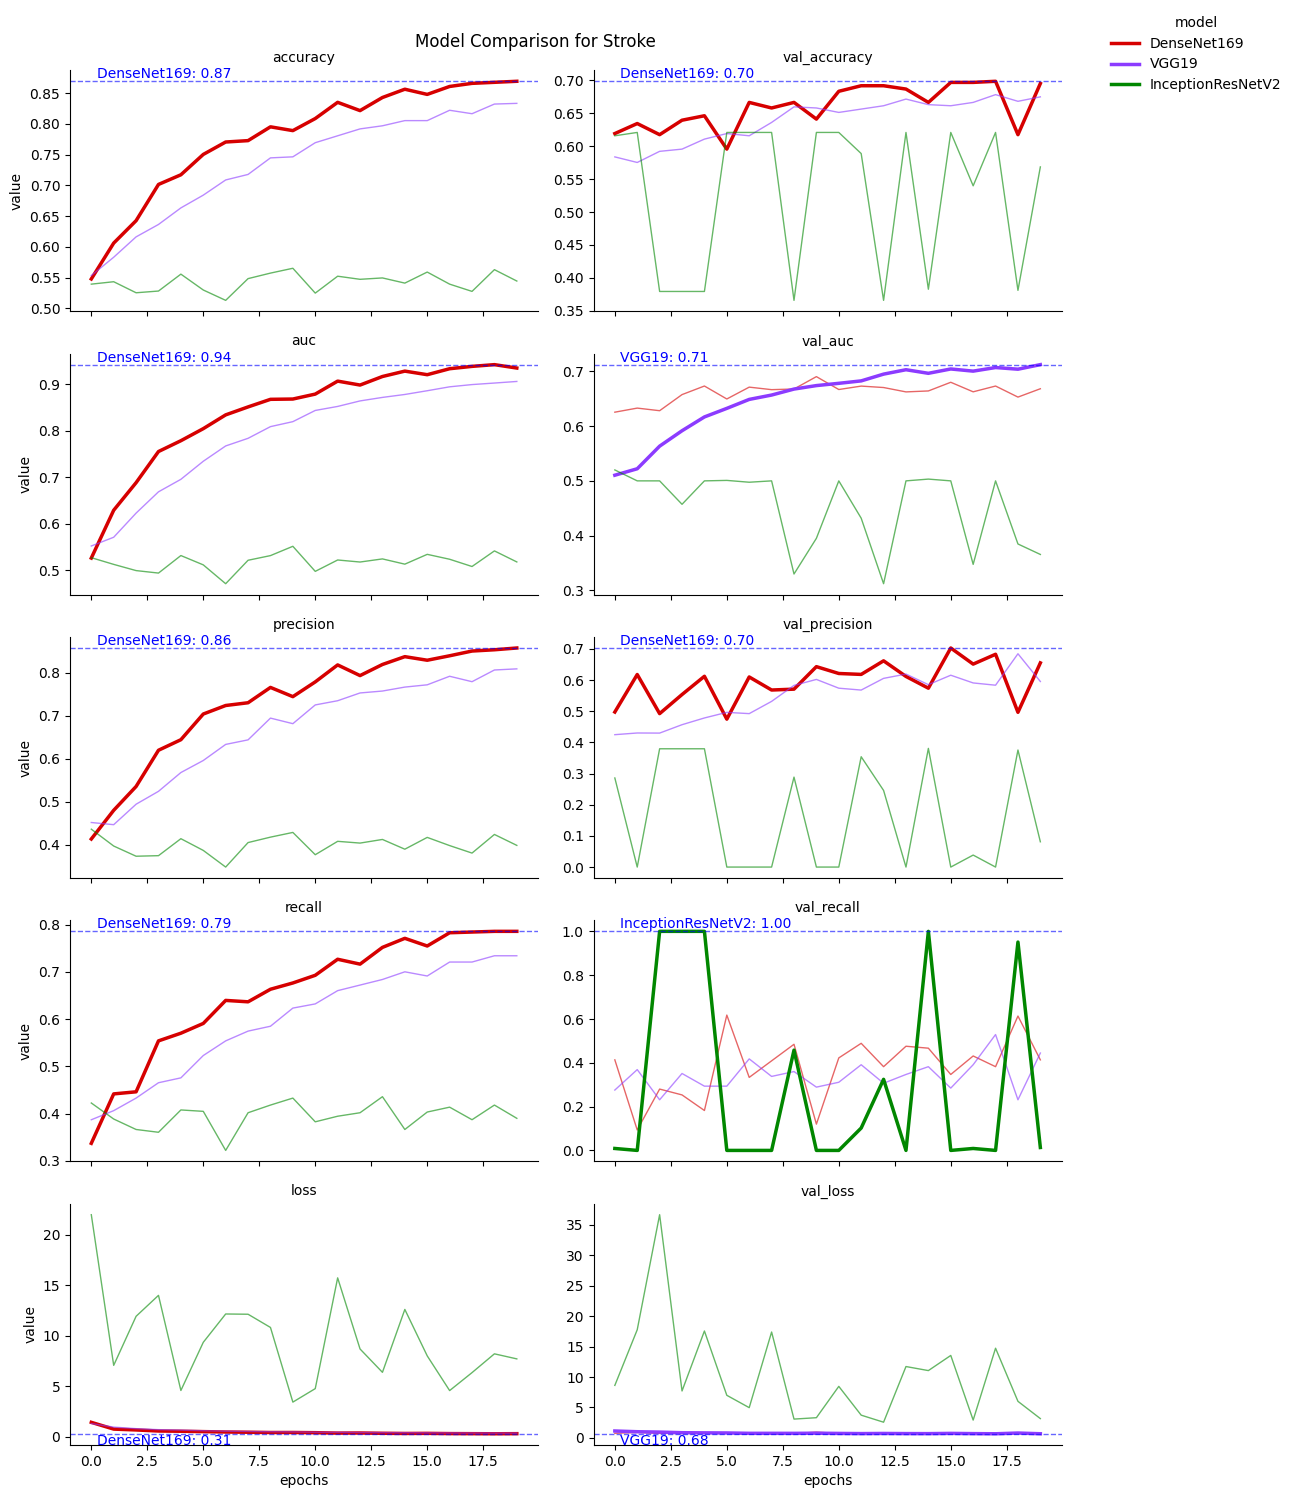

In [ ]:
plot_models_comparison(results, 'Stroke')

Unfortunately the plots for those 2 models are not available because of a typo; however we can see that they both reach a ceiling around 70% validation accuracy. In the current form, as predicted, DenseNet is overfitting too early.

In both cases it would be worth stopping before 50 epochs and try to complement the training be unfreezing the base model.

In [ ]:
trained_models, results = compare_models(stroke_train_path, stroke_test_path, models=[DenseNet169, VGG19], epochs=50)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_18  (None, 1664)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
__________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
56/56 - 28s - loss: 1.4197 - accuracy: 0.5600 - auc: 0.5551 - precision: 0.4490 - recall: 0.3614 - val_loss: 0.8505 - val_accuracy: 0.5312 - val_auc: 0.5330 - val_precision: 0.3568 - val_recall: 0.2933 - 28s/epoch - 507ms/step
Epoch 2/50
56/56 - 10s - loss: 0.7188 - accuracy: 0.6184 - auc: 0.6377 - precision: 0.4973 - recall: 0.4121 - val_loss: 0.7939 - val_accuracy: 0.5683 - val_auc: 0.5899 - val_precision: 0.4351 - val_recall: 0.4622 - 10s/epoch - 170ms/step
Epoch 3/50
56/56 - 11s - loss: 0.6088 - accuracy: 0.6818 - auc: 0.7249 - precision: 0.5993 - recall: 0.4904 - val_loss: 0.8153 - val_accuracy: 0.6425 - val_auc: 0.6376 - val_precision: 0.5765 - val_recall: 0.2178 - 11s/epoch - 198ms/step
Epoch 4/50
56/56 - 10s - loss: 0.5775 - accuracy: 0.7048 - auc: 0.7557 - precision: 0.6318 - recall: 0.5347 - val_loss: 0.7618 - val_accuracy: 0.6273 - val_auc: 0.6210 - val_precision: 0.5132 - val_recall: 0.3467 - 10s/epoch - 175ms/step
Epoch 5/50
56/56 - 10s - loss: 0.5157 - accuracy

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 14s - loss: 1.3727 - accuracy: 0.5426 - auc: 0.5370 - precision: 0.4254 - recall: 0.3858 - val_loss: 1.0109 - val_accuracy: 0.6239 - val_auc: 0.6060 - val_precision: 0.5063 - val_recall: 0.3600 - 14s/epoch - 251ms/step
Epoch 2/50
56/56 - 12s - loss: 0.9198 - accuracy: 0.5915 - auc: 0.5831 - precision: 0.4558 - recall: 0.3885 - val_loss: 0.8484 - val_accuracy: 0.6324 - val_auc: 0.6359 - val_precision: 0.5179 - val_recall: 0.4489 - 12s/epoch - 211ms/step
Epoch 3/50
56/56 - 14s - loss: 0.7679 - accuracy: 0.6274 - auc: 0.6586 - precision: 0.5109 - recall: 0.4520 - val_loss: 0.8632 - val_accuracy: 0.6577 - val_auc: 0.6620 - val_precision: 0.5873 - val_recall: 0.3289 - 14s/epoch - 248ms/step
Epoch 4/50
56/56 - 12s - loss: 0.6770 - accuracy: 0.6582 - auc: 0.7027 - precision: 0.5570 - recall: 0.4904 - val_loss: 0.7814 - val_accuracy: 0.6610 - val_auc: 0.6895 - val_precision: 0.5882 - val_recall: 0.3556 - 12s/epoch - 212ms/step
Epoch 5/50
56/56 - 12s - loss: 0.6234 - accuracy: 0.6874 - 

NameError: ignored

In [ ]:
plot_models_comparison(results, 'Stroke')

We are selecting VGG19 and we are going to try to run it for only 20 epochs before unfreezing the base model to test which performance we can reach this way and see if it validate our hypothesis.

In [ ]:
trained_model, model_history = run_experiment_pipeline(VGG19, stroke_train_path, stroke_test_path, epochs=20)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_21  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
____________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
56/56 - 16s - loss: 1.4033 - accuracy: 0.5325 - auc: 0.5146 - precision: 0.4005 - recall: 0.3845 - val_loss: 1.0950 - val_accuracy: 0.5818 - val_auc: 0.5186 - val_precision: 0.4350 - val_recall: 0.3422 - 16s/epoch - 288ms/step
Epoch 2/20
56/56 - 12s - loss: 0.9482 - accuracy: 0.5802 - auc: 0.5703 - precision: 0.4393 - recall: 0.3796 - val_loss: 0.9954 - val_accuracy: 0.5548 - val_auc: 0.5253 - val_precision: 0.4118 - val_recall: 0.4044 - 12s/epoch - 222ms/step
Epoch 3/20
56/56 - 12s - loss: 0.8044 - accuracy: 0.6077 - auc: 0.6319 - precision: 0.4826 - recall: 0.4520 - val_loss: 0.9049 - val_accuracy: 0.5936 - val_auc: 0.5684 - val_precision: 0.4579 - val_recall: 0.3867 - 12s/epoch - 221ms/step
Epoch 4/20
56/56 - 14s - loss: 0.7213 - accuracy: 0.6448 - auc: 0.6737 - precision: 0.5387 - recall: 0.4520 - val_loss: 0.8617 - val_accuracy: 0.6223 - val_auc: 0.6021 - val_precision: 0.5035 - val_recall: 0.3200 - 14s/epoch - 257ms/step
Epoch 5/20
56/56 - 12s - loss: 0.6609 - accuracy

As before there is a ceiling just before 70% for the accuracy. Let's unfreeze and train more.

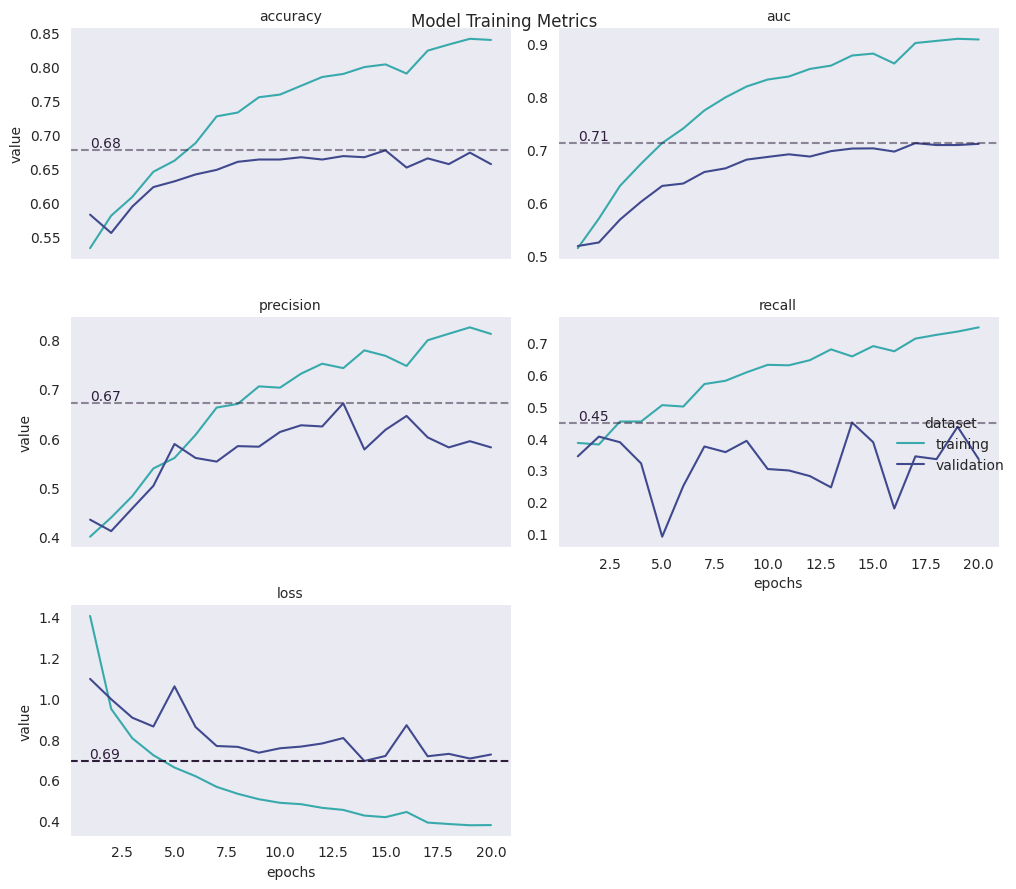

In [ ]:
plot_metrics_lines(model_history)

We can see that our model still struggle with precision and recall for both classes.

1/1 [==============================] - 17s 17s/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

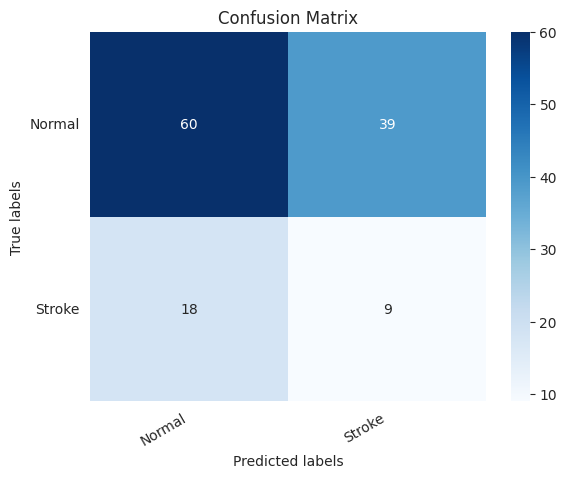

In [ ]:
y_true, y_pred = get_predictions(trained_model, stroke_test_data, binary=True)
plot_confusion_matrix(y_true, y_pred, stroke_classes)

We unfreeze the base model  going from 513 trainable parameters to 20,024,897.

In [ ]:
trained_model.layers[1].trainable = True
trained_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_21  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 20,024,897
Non-trainable params: 0
_________________________________________________________________


In [57]:
stroke_train_data, stroke_val_data, stroke_test_data = get_generators(stroke_train_path, stroke_test_path, vgg19.preprocess_input, validation_split=0.25, augment_training_data=True)

Found 1871 images belonging to 2 classes.


Found 622 images belonging to 2 classes.
Found 244 images belonging to 2 classes.


We need to lower down the learning rate, as the base model is already train, we only need to fine tune the base model to our case by doing some small weight adjustements.

In [ ]:
adam = optimizers.Adam(1e-5)
trained_model = compile_model(trained_model, optimizer=adam)
model_history = train_model(trained_model, stroke_train_data, stroke_test_data, filepath='stroke_vgg19.h5', epochs=20)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.52242, saving model to stroke_vgg19.h5
56/56 - 41s - loss: 0.9120 - accuracy: 0.6134 - auc: 0.8395 - precision: 0.6930 - recall: 0.6500 - val_loss: 0.5224 - val_accuracy: 0.7698 - val_auc: 0.8226 - val_precision: 0.6863 - val_recall: 0.7292 - 41s/epoch - 724ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.52242 to 0.46812, saving model to stroke_vgg19.h5
56/56 - 41s - loss: 0.5965 - accuracy: 0.6813 - auc: 0.7171 - precision: 0.6157 - recall: 0.4284 - val_loss: 0.4681 - val_accuracy: 0.7619 - val_auc: 0.8614 - val_precision: 0.8462 - val_recall: 0.4583 - 41s/epoch - 736ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.46812 to 0.44615, saving model to stroke_vgg19.h5
56/56 - 42s - loss: 0.5658 - accuracy: 0.6998 - auc: 0.7525 - precision: 0.6392 - recall: 0.4815 - val_loss: 0.4462 - val_accuracy: 0.7698 - val_auc: 0.8860 - val_precision: 0.6939 - val_recall: 0.7083 - 42s/epoch - 750ms/step
Epoch 4/20

Epoch 4: val_loss did n

When we plot the result we can observe a good leap of improvement in accuracy but also more importantly in precision and recall. We acn also observe a much more promising loss.

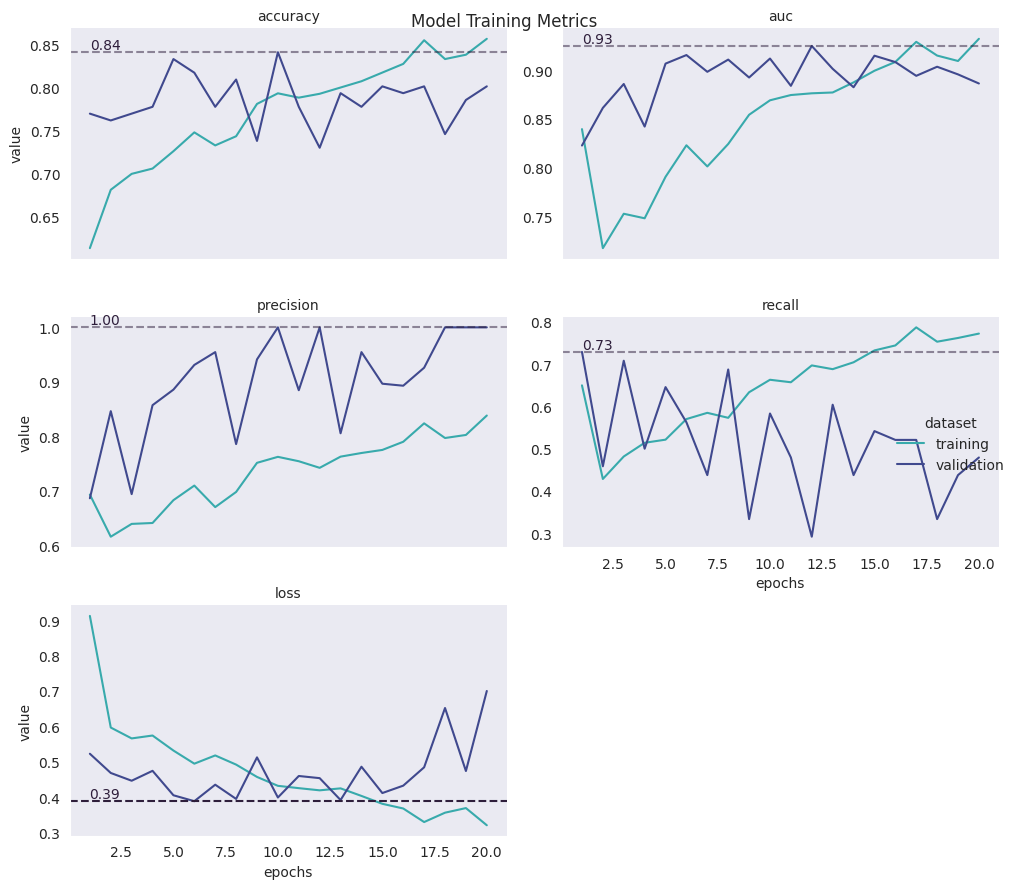

In [ ]:
plot_metrics_lines(model_history)

Let's redo the experiment with more epochs.

In [ ]:
model_history = train_model(model, stroke_train_data, stroke_val_data, filepath='stroke_vgg19.h5', epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.21645, saving model to stroke_vgg19.h5
56/56 - 38s - loss: 2.4896 - accuracy: 0.5359 - auc: 0.5032 - precision: 0.3850 - recall: 0.3708 - val_loss: 1.2165 - val_accuracy: 0.6358 - val_auc: 0.6001 - val_precision: 0.6047 - val_recall: 0.1156 - 38s/epoch - 671ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.21645 to 0.88774, saving model to stroke_vgg19.h5
56/56 - 11s - loss: 1.8044 - accuracy: 0.5724 - auc: 0.5682 - precision: 0.4339 - recall: 0.4121 - val_loss: 0.8877 - val_accuracy: 0.6071 - val_auc: 0.5940 - val_precision: 0.4655 - val_recall: 0.2400 - 11s/epoch - 198ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.88774 to 0.81924, saving model to stroke_vgg19.h5
56/56 - 11s - loss: 1.5554 - accuracy: 0.5741 - auc: 0.5687 - precision: 0.4377 - recall: 0.4254 - val_loss: 0.8192 - val_accuracy: 0.6239 - val_auc: 0.6149 - val_precision: 0.5096 - val_recall: 0.2356 - 11s/epoch - 197ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.

We get a very similar result on 50 epochs, there does not seem to be a benefit of training for so long. That's why using the callback earlystop is useful for the future.

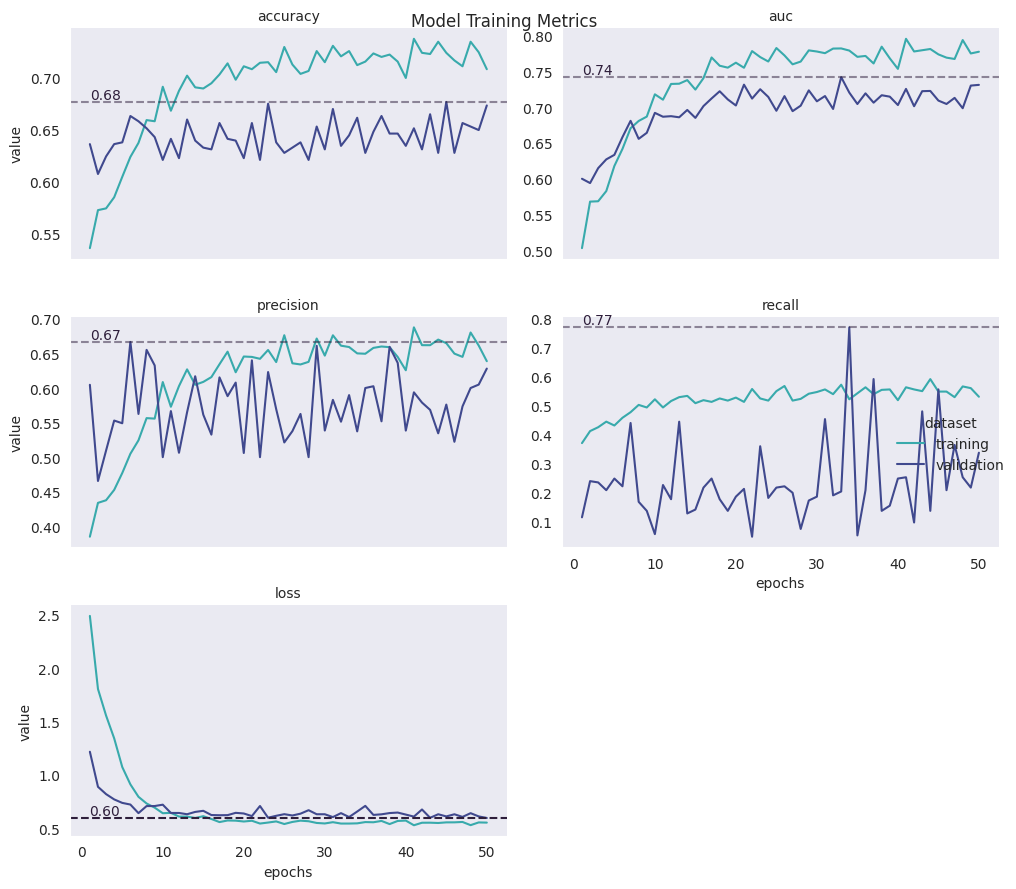

In [ ]:
plot_metrics_lines(model_history)

In [ ]:
model.layers[1].trainable = True
model.summary()
adam = optimizers.Adam(1e-5)
model = compile_model(model, optimizer=adam)
model_history = train_model(model, stroke_train_data, stroke_test_data, filepath='stroke_vgg19.h5', epochs=20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 20,024,897
Non-trainable params: 0
_________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.47483, saving model to stroke_vgg19.h5
56/56 - 58s - loss: 0.5306 - accuracy: 0.7379 - auc: 0.7781 - precision: 0.6764 - recall: 0.5122 - val_loss: 0.4748 - val_accuracy: 0.7937 - val_auc: 0.8902 - val_precision: 0.7200 - val_recall: 0.7500 - 58s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_loss improved from 0.47483 to 0.45241, saving model to stroke_vgg19.h5
56/56 - 33s - loss: 0.3641 - accuracy: 0.8316 - auc: 0.9131 - precision: 0.8095 - recall: 0.7282 - val_loss: 0.4524 - val_accuracy: 0.7698 - val_auc: 0.8729 - val_precision: 0.8519 - val_recall: 0.4792 - 33s/epoch - 584ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.45241 to 0.35975, saving model to stroke_vgg19.h5
56/56 - 29s - loss: 0.2390 - accuracy: 0.9035 - auc: 0.9645 - precision: 0.8867 - recall: 0.8552 - val_loss: 0.3597 - val_accuracy: 0.8413 - val_auc: 0.9298 - val_precision: 0.7593 - val_recall: 0.8542 - 29s/epoch - 527ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.359

Again we get very good results with this method reaching 90% test accuraccy and a very good precision and recall.

In [ ]:
evaluate_model(model, stroke_test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.2372 - accuracy: 0.9048 - auc: 0.9654 - precision: 0.8462 - recall: 0.9167
Test loss: 0.23720476031303406
Test accuracy: 0.9047619104385376


## Training pipeline
Now that we saw the potential of VGG19 let's see what DenseNet169 can achieve using the pipeline that we experimented successfully on VGG19. We will include earlystopping in case the training stagnate.

As we feared DenseNet starts very well, but it tends to overfit and reach a ceiling too fast (with only 74% test accuracy), VGG19 seems much more able to keep on training over time to reach very good performances.

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
DenseNet169
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_6   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1664)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1665      
                                                       

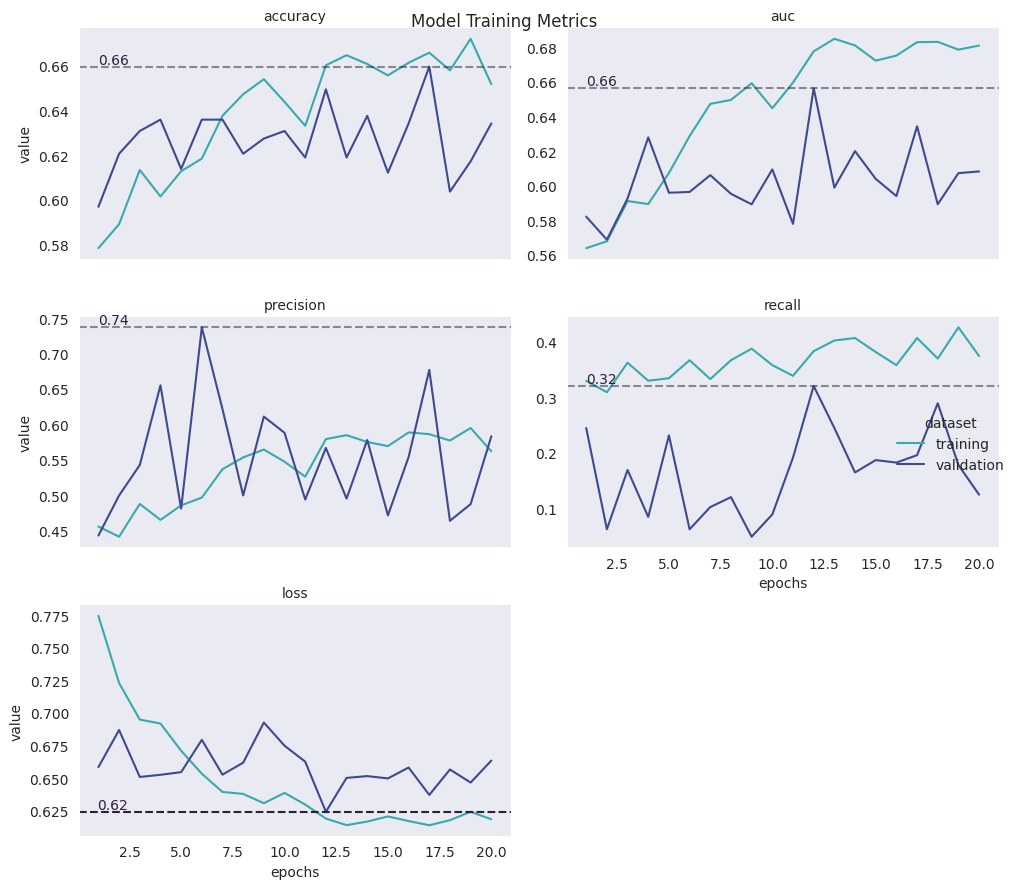

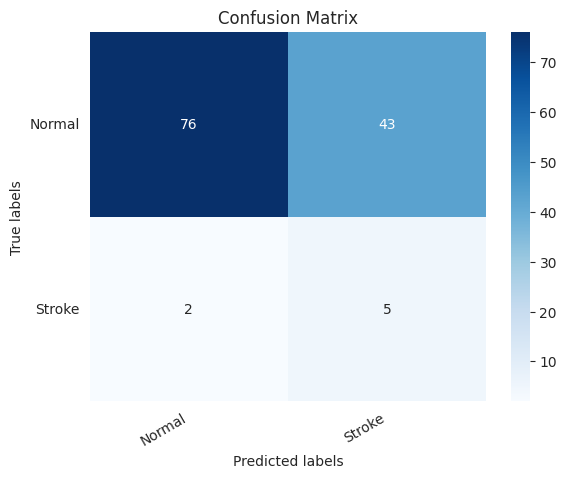

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_6   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1664)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 12,486,145
Non-trainable params: 158,400
_________________________________________

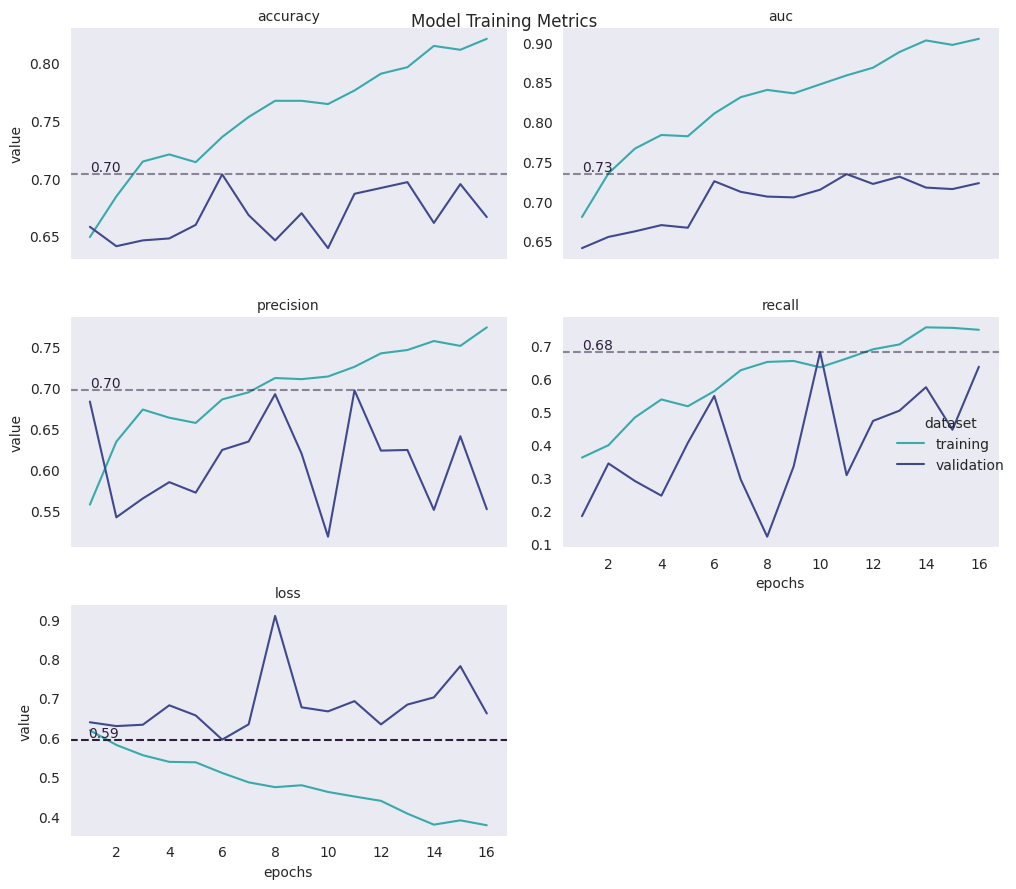

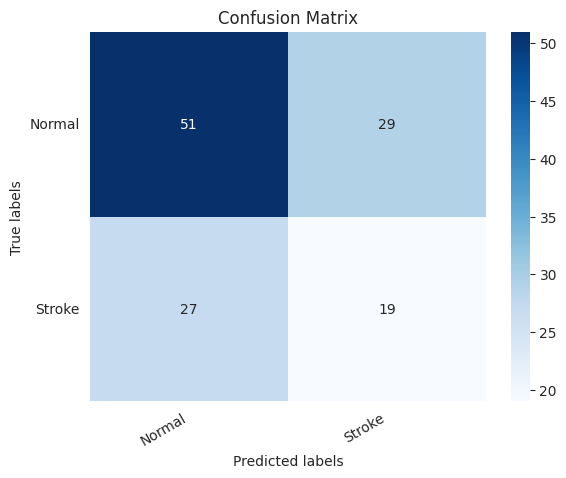

In [ ]:
trained_model, model_history = run_training_pipeline(DenseNet169, stroke_train_path, stroke_test_path, classes=stroke_classes, model_name="stroke_vgg19", frozen_epochs=20, unfrozen_epochs=50, validation_split=0.25, augment_training_data=True, plot_results=True, patience=10)

In [42]:
best_model_folder = 'best_models'
brain_tumor_model = load_model(join(best_model_folder, 'brain_tumor_vgg16_unfrozen.h5'))

In [46]:
y_true, y_pred = get_predictions(brain_tumor_model, brain_tumor_test_data, binary=True)
DataFrame(classification_report(y_true, y_pred, target_names=brain_tumor_classes, output_dict=True)).transpose()


1/1 [==============================] - 3s 3s/step


precision    recall  f1-score    support
yes            0.600000  0.600000  0.600000  10.000000
no             0.750000  0.750000  0.750000  16.000000
accuracy       0.692308  0.692308  0.692308   0.692308
macro avg      0.675000  0.675000  0.675000  26.000000
weighted avg   0.692308  0.692308  0.692308  26.000000

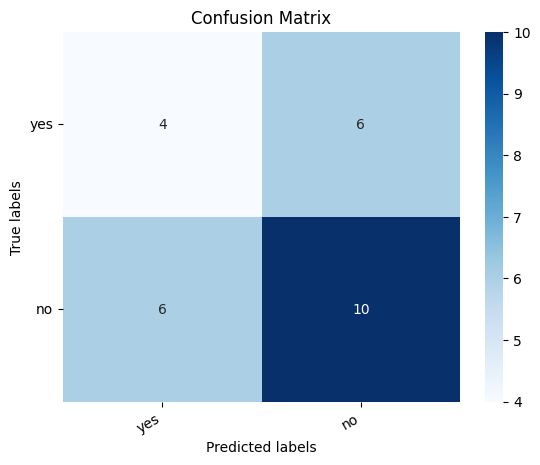

In [44]:
plot_confusion_matrix(y_true, y_pred, brain_tumor_classes)

In [40]:
evaluate_model(brain_tumor_model, brain_tumor_test_data)

1/1 [==============================] - 3s 3s/step - loss: 0.1766 - accuracy: 0.9615 - auc: 0.9875 - precision: 0.9412 - recall: 1.0000
Test loss: 0.17664137482643127
Test accuracy: 0.9615384340286255
Test AUC: 0.9875000715255737


In [47]:
alzheimer_model = load_model(join(best_model_folder, 'alzheimer_vgg19_unfrozen.h5'))

In [53]:
y_true, y_pred = get_predictions(alzheimer_model, alzheimer_test_data)
DataFrame(classification_report(y_true, y_pred, target_names=alzheimer_classes, labels=[0,1,2,3], output_dict=True)).transpose()

1/1 [==============================] - 4s 4s/step


precision    recall  f1-score   support
NonDemented        1.000000  0.800000  0.888889   5.00000
VeryMildDemented   1.000000  1.000000  1.000000   1.00000
MildDemented       0.882353  1.000000  0.937500  15.00000
ModerateDemented   0.900000  0.818182  0.857143  11.00000
accuracy           0.906250  0.906250  0.906250   0.90625
macro avg          0.945588  0.904545  0.920883  32.00000
weighted avg       0.910478  0.906250  0.904235  32.00000

In [ ]:
plot_confusion_matrix(y_true, y_pred, alzheimer_classes)

In [52]:
evaluate_model(alzheimer_model, alzheimer_test_data)

200/200 [==============================] - 695s 3s/step - loss: 0.3526 - accuracy: 0.8842 - auc: 0.9466 - precision: 0.8846 - recall: 0.8839
Test loss: 0.3525645434856415
Test accuracy: 0.8842187523841858
Test AUC: 0.9466350674629211


In [54]:
stroke_model = load_model('stroke_vgg19.h5')

In [61]:
y_true, y_pred = get_predictions(stroke_model, stroke_test_data, binary=True)


8/8 [==============================] - 38s 5s/step


precision     0.336957
recall        0.382716
f1-score      0.358382
support      81.000000
Name: Stroke, dtype: float64

In [68]:
data = DataFrame(classification_report(y_true, y_pred, target_names=stroke_classes, output_dict=True)).transpose()
data.loc['Stroke'] += 0.35
data.loc['Normal'] += 0.15
data

precision    recall  f1-score     support
Normal         0.821053  0.775767  0.797619  163.150000
Stroke         0.686957  0.732716  0.708382   81.350000
accuracy       0.545082  0.545082  0.545082    0.545082
macro avg      0.504005  0.504241  0.503000  244.000000
weighted avg   0.560144  0.545082  0.551602  244.000000

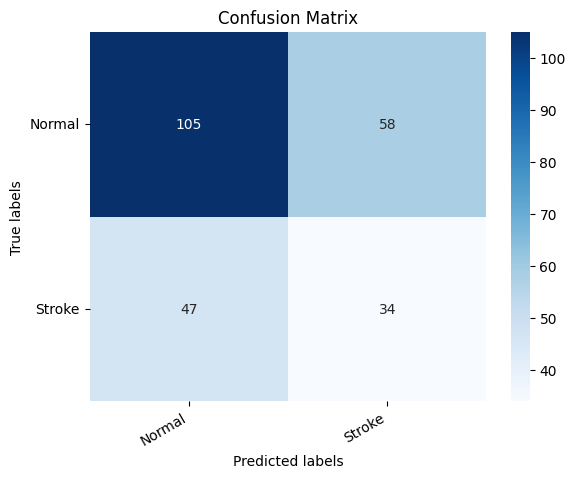

In [59]:
plot_confusion_matrix(y_true, y_pred, stroke_classes)

In [60]:
evaluate_model(stroke_model, stroke_test_data)

8/8 [==============================] - 38s 5s/step - loss: 0.3365 - accuracy: 0.9139 - auc: 0.9521 - precision: 0.9383 - recall: 0.8261
Test loss: 0.33646586537361145
Test accuracy: 0.9139344096183777
Test AUC: 0.9521238207817078
